# Modeling for daily data

In [1]:
# libs
# system
from datetime import datetime
import math
import random

# data prep
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# model
import lightgbm as lgb
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
xlsx_df = pd.read_excel('AirQualityUCI/AirQualityUCI.xlsx', sep=';')
xlsx_df.head(2)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.6,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.3,47.700000,0.725487


Are there any NaN value:  False


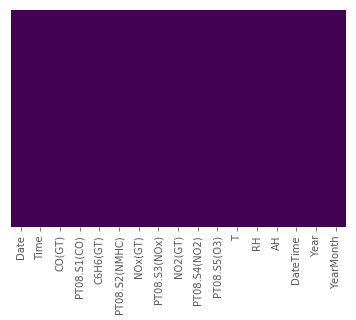

In [3]:
xlsx_df.replace(to_replace= -200, value= np.NaN, inplace= True)

xlsx_df.drop(['NMHC(GT)'], axis= 1, inplace= True)
# date
xlsx_df['DateTime'] = xlsx_df['Date'].astype(str) + ' ' + xlsx_df['Time'].astype(str)
xlsx_df['DateTime'] = pd.to_datetime(xlsx_df['DateTime'], format='%Y-%m-%d %H:%M:%S')

xlsx_df['Date'] = pd.to_datetime(xlsx_df['Date'].astype(str), format='%Y-%m-%d')

# for year trend visualization perpose, this helps
xlsx_df['Year'] = xlsx_df['DateTime'].map(lambda x: x.year)

xlsx_df['YearMonth'] = pd.to_datetime(xlsx_df.DateTime).dt.to_period('m')

# fill NaN
interpolateList = [x for x in xlsx_df.columns if x not in ['Date', 'Time', 'DateTime', 'Year', 'YearMonth']]

# interpolatoin 
for col in interpolateList:
    xlsx_df[col].interpolate(method='linear', inplace=True)
    
print('Are there any NaN value: ', xlsx_df.isnull().values.any())
# show missing value again
sns.heatmap(xlsx_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

#### Daily mean
* If the goal is to predict the air quality index of next 5 **days**, one should calculate daily `mean`

In [4]:
dummyframe = xlsx_df.set_index(['DateTime'])
day_xlsx_df = xlsx_df.groupby(dummyframe.index.date).mean().copy()
day_xlsx_df.head(2)

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Year
2004-03-10,1.966667,1316.5000,8.460790,912.250000,132.00,1167.2500,108.833333,1545.333333,1096.041667,12.020833,54.883334,0.765626,2004
2004-03-11,2.172917,1244.0625,7.989058,851.802083,139.75,1277.1875,97.666667,1522.697917,885.031250,9.833333,64.069791,0.775768,2004


In [5]:
day_xlsx_df = day_xlsx_df.reset_index()
day_xlsx_df.head(2)

,index,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Year
0,2004-03-10,1.966667,1316.5000,8.460790,912.250000,132.00,1167.2500,108.833333,1545.333333,1096.041667,12.020833,54.883334,0.765626,2004
1,2004-03-11,2.172917,1244.0625,7.989058,851.802083,139.75,1277.1875,97.666667,1522.697917,885.031250,9.833333,64.069791,0.775768,2004


In [6]:
day_xlsx_df['YearMonth'] = pd.to_datetime(day_xlsx_df['index'].values).to_period('m')
print(day_xlsx_df['YearMonth'].iloc[:2])

0    2004-03
1    2004-03
Name: YearMonth, dtype: period[M]


In [7]:
print('orginal dataframe shape: ', xlsx_df.shape)
print('after get daily mean, dataframe shape: ', day_xlsx_df.shape)
day_xlsx_df.head(2)

orginal dataframe shape:  (9357, 17)
after get daily mean, dataframe shape:  (391, 15)


,index,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Year,YearMonth
0,2004-03-10,1.966667,1316.5000,8.460790,912.250000,132.00,1167.2500,108.833333,1545.333333,1096.041667,12.020833,54.883334,0.765626,2004,2004-03
1,2004-03-11,2.172917,1244.0625,7.989058,851.802083,139.75,1277.1875,97.666667,1522.697917,885.031250,9.833333,64.069791,0.775768,2004,2004-03


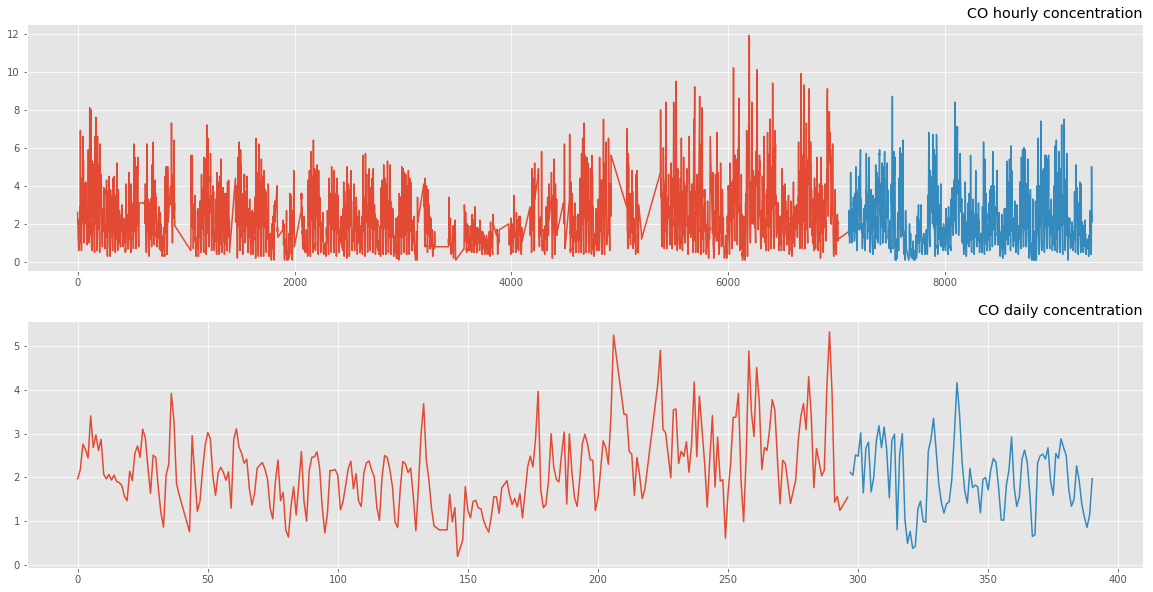

In [8]:
import matplotlib
# observe trend.
plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)
year1 = 2004
year2 = 2005
plt.plot(xlsx_df.index[xlsx_df["Year"] == year1], xlsx_df.loc[xlsx_df["Year"] == year1]["CO(GT)"].values)
plt.plot(xlsx_df.index[xlsx_df["Year"] == year2], xlsx_df.loc[xlsx_df["Year"] == year2]["CO(GT)"].values)
plt.title("CO hourly concentration", loc='right')

plt.subplot(2, 1, 2)    
plt.plot(day_xlsx_df.index[day_xlsx_df["Year"] == year1], day_xlsx_df.loc[day_xlsx_df["Year"] == year1]["CO(GT)"].values)
plt.plot(day_xlsx_df.index[day_xlsx_df["Year"] == year2], day_xlsx_df.loc[day_xlsx_df["Year"] == year2]["CO(GT)"].values)
plt.title("CO daily concentration", loc='right')
plt.show()

#### feature selection
* minimum feature(s): select `C6H6`, `NOx` and `NO2` at first, because `T`, `RH`, `AH` show very low correlation (almost `0`) with label `CO`. In this way, one can lower the possibility of overfitting.

In [9]:
featureList = ["YearMonth", "CO(GT)", "C6H6(GT)", "NOx(GT)", "PT08.S5(O3)"]

df = day_xlsx_df[featureList].copy() # copy())prevent SettingwithCopyWarning
df.rename(columns={"CO(GT)": "CO", "C6H6(GT)": "C6H6", "NOx(GT)": "NOx"}, inplace=True) # rename column by passing a dict
print('after get daily mean, dataframe shape: ', df.shape)
df.head(2)

after get daily mean, dataframe shape:  (391, 5)


,YearMonth,CO,C6H6,NOx,PT08.S5(O3)
0,2004-03,1.966667,8.460790,132.00,1096.041667
1,2004-03,2.172917,7.989058,139.75,885.031250


#### shift n days for regression model
In this mission, it is required to shift `n = 5` days

In [10]:
numWePredict = 5 # number of days that we want to predict

In [11]:
shift_col_name = "NO2(GT)" # choose the chemical you want

In [12]:
futureYList = []
# generate sequence (label y)
for n in range(1, numWePredict+1):
    colStr = shift_col_name + "(+" + str(n) + ")"
    df[colStr] = xlsx_df[shift_col_name].shift(-n)
    futureYList.append(colStr)
df.dropna(inplace=True) # drop last n(n = numWePredict) rows with NaN
print('futureYList we want to track: ', futureYList)
df.tail(2)

futureYList we want to track:  ['NO2(GT)(+1)', 'NO2(GT)(+2)', 'NO2(GT)(+3)', 'NO2(GT)(+4)', 'NO2(GT)(+5)']


,YearMonth,CO,C6H6,NOx,PT08.S5(O3),NO2(GT)(+1),NO2(GT)(+2),NO2(GT)(+3),NO2(GT)(+4),NO2(GT)(+5)
389,2005-04,1.141667,4.318307,167.662500,716.972222,87.0,79.0,78.0,70.5,63.0
390,2005-04,1.970000,8.435233,263.253333,995.133333,79.0,78.0,70.5,63.0,48.0


### Modeling
* LGBM
    * multi-variate regression model
* RNN

#### trains models
* use data range from 2004/03 ~ 2004/12

In [13]:
df_X = df[[x for x in df.columns if x not in futureYList]]
df_y = df[futureYList] # n (n = numWePredict) labels
print('df_X: \n', df_X.head(2))
print('\n')
print('df_y: \n', df_y.head(2))
print('\n')
print('futureYList: ', futureYList)

df_X: 
   YearMonth        CO      C6H6     NOx  PT08.S5(O3)
0   2004-03  1.966667  8.460790  132.00  1096.041667
1   2004-03  2.172917  7.989058  139.75   885.031250


df_y: 
    NO2(GT)(+1)  NO2(GT)(+2)  NO2(GT)(+3)  NO2(GT)(+4)  NO2(GT)(+5)
0         92.0        114.0        122.0        116.0         96.0
1        114.0        122.0        116.0         96.0         77.0


futureYList:  ['NO2(GT)(+1)', 'NO2(GT)(+2)', 'NO2(GT)(+3)', 'NO2(GT)(+4)', 'NO2(GT)(+5)']


In [14]:
year2004PeriodArray = [x for x in df_X.YearMonth.unique() if x.year == 2004 ]
print(year2004PeriodArray)
X_train = df_X.loc[df_X.YearMonth.isin(year2004PeriodArray)].copy()
y_train = df_y.loc[df_X.YearMonth.isin(year2004PeriodArray)].copy()
print('\n')
print('X_train: \n', X_train.head(2))
print('\n')
print('y_train: \n', y_train.head(2))

[Period('2004-03', 'M'), Period('2004-04', 'M'), Period('2004-05', 'M'), Period('2004-06', 'M'), Period('2004-07', 'M'), Period('2004-08', 'M'), Period('2004-09', 'M'), Period('2004-10', 'M'), Period('2004-11', 'M'), Period('2004-12', 'M')]


X_train: 
   YearMonth        CO      C6H6     NOx  PT08.S5(O3)
0   2004-03  1.966667  8.460790  132.00  1096.041667
1   2004-03  2.172917  7.989058  139.75   885.031250


y_train: 
    NO2(GT)(+1)  NO2(GT)(+2)  NO2(GT)(+3)  NO2(GT)(+4)  NO2(GT)(+5)
0         92.0        114.0        122.0        116.0         96.0
1        114.0        122.0        116.0         96.0         77.0


#### validates models
* use data range from 2005/01 ~ 2005/04

In [15]:
year2005PeriodArray = [x for x in df_X.YearMonth.unique() if x.year == 2005 ]
print(year2005PeriodArray)

X_valid = df_X.loc[df_X.YearMonth.isin(year2005PeriodArray)].copy()
y_valid = df_y.loc[df_X.YearMonth.isin(year2005PeriodArray)].copy()
X_valid.reset_index(inplace=True)
y_valid.reset_index(inplace=True)
X_valid.drop(columns=['index'], inplace=True)
y_valid.drop(columns=['index'], inplace=True)

print('X_valid shape: ', X_valid.shape)
print('y_valid shape: ', y_valid.shape)
print('\n')
print('X_valid: \n', X_valid.head(2))
print('\n')
print('y_valid: \n', y_valid.head(2))

[Period('2005-01', 'M'), Period('2005-02', 'M'), Period('2005-03', 'M'), Period('2005-04', 'M')]
X_valid shape:  (94, 5)
y_valid shape:  (94, 5)


X_valid: 
   YearMonth        CO      C6H6         NOx  PT08.S5(O3)
0   2005-01  2.112328  7.173114  305.630649  1226.288194
1   2005-01  2.045833  6.958703  318.958333  1306.778498


y_valid: 
    NO2(GT)(+1)  NO2(GT)(+2)  NO2(GT)(+3)  NO2(GT)(+4)  NO2(GT)(+5)
0         31.0         22.0         47.0         88.0        130.0
1         22.0         47.0         88.0        130.0        132.0


### Normalization
* features normalization: change solution space into a uniform shape

In [16]:
# training / testing set
normColList = [x for x in X_train.columns if x not in ['YearMonth']]
min_max_scaler = MinMaxScaler() # call MinMaxScaler object
X_train_norm = pd.DataFrame(min_max_scaler.fit_transform(X_train[normColList].values), columns=normColList) # feed in a numpy array
# concat dfs
X_train_norm = pd.concat( [X_train[['YearMonth']], X_train_norm], axis=1)
X_train_norm.head(2)

,YearMonth,CO,C6H6,NOx,PT08.S5(O3)
0,2004-03,0.346322,0.306103,0.125254,0.449335
1,2004-03,0.386517,0.285561,0.135067,0.316928


In [17]:
# validation set
min_max_scaler = MinMaxScaler() # call MinMaxScaler object
X_valid_norm = pd.DataFrame(min_max_scaler.fit_transform(X_valid[normColList].values), columns=normColList) # feed in a numpy array
# concat dfs
X_valid_norm = pd.concat( [X_valid[['YearMonth']], X_valid_norm], axis=1)
X_valid_norm.head(2)

,YearMonth,CO,C6H6,NOx,PT08.S5(O3)
0,2005-01,0.458419,0.342750,0.390219,0.523442
1,2005-01,0.440853,0.328638,0.418215,0.577390


#### hyperparameter tuning
* Grid search

In [18]:
# basic hyperparameters for linear regression
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 40,
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 2,
    'verbose': 0
}

Starting training...
startYearMonth:  2004-03
X_train_walk:
   YearMonth        CO      C6H6       NOx  PT08.S5(O3)
0   2004-03  0.346322  0.306103  0.125254     0.449335
1   2004-03  0.386517  0.285561  0.135067     0.316928
y_train_walk:
 0     92.0
1    114.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
83   2004-06  0.310593  0.476581  0.143509     0.430955
84   2004-06  0.185491  0.253535  0.045348     0.278056
y_test_walk:
 83    63.0
84    67.0
Name: NO2(GT)(+1), dtype: float64
labelY:  NO2(GT)(+1)
[1]	valid_0's l2: 867.921	valid_0's l1: 24.6187
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 867.051	valid_0's l1: 24.6097
[3]	valid_0's l2: 866.259	valid_0's l1: 24.6049
[4]	valid_0's l2: 865.477	valid_0's l1: 24.6001
[5]	valid_0's l2: 864.781	valid_0's l1: 24.5938
[6]	valid_0's l2: 864.505	valid_0's l1: 24.5949
[7]	valid_0's l2: 864.56	valid_0's l1: 24.6002
[8]	valid_0's l2: 864.282	valid_0'

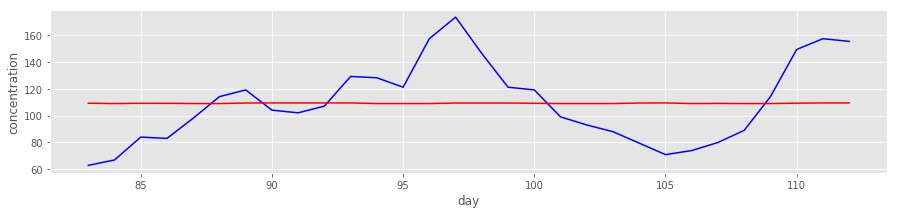

X_train_walk:
   YearMonth        CO      C6H6       NOx  PT08.S5(O3)
0   2004-03  0.346322  0.306103  0.125254     0.449335
1   2004-03  0.386517  0.285561  0.135067     0.316928
y_train_walk:
 0    114.0
1    122.0
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
83   2004-06  0.310593  0.476581  0.143509     0.430955
84   2004-06  0.185491  0.253535  0.045348     0.278056
y_test_walk:
 83    67.0
84    84.0
Name: NO2(GT)(+2), dtype: float64
labelY:  NO2(GT)(+2)
[1]	valid_0's l2: 820.317	valid_0's l1: 23.9167
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 819.933	valid_0's l1: 23.9133
[3]	valid_0's l2: 819.075	valid_0's l1: 23.8997
[4]	valid_0's l2: 818.227	valid_0's l1: 23.8861
[5]	valid_0's l2: 817.696	valid_0's l1: 23.8806
[6]	valid_0's l2: 817.451	valid_0's l1: 23.8792
[7]	valid_0's l2: 817.649	valid_0's l1: 23.8839
[8]	valid_0's l2: 817.358	valid_0's l1: 23.8803
[9]	valid_0's l2: 816.817	valid

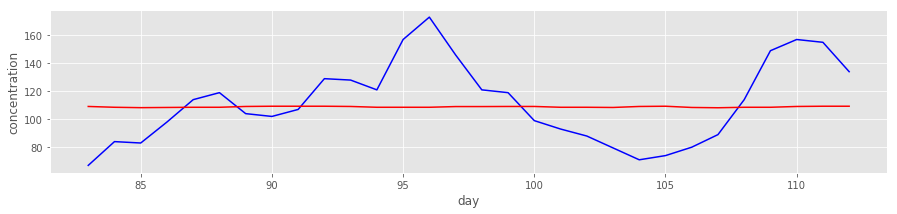

X_train_walk:
   YearMonth        CO      C6H6       NOx  PT08.S5(O3)
0   2004-03  0.346322  0.306103  0.125254     0.449335
1   2004-03  0.386517  0.285561  0.135067     0.316928
y_train_walk:
 0    122.0
1    116.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
83   2004-06  0.310593  0.476581  0.143509     0.430955
84   2004-06  0.185491  0.253535  0.045348     0.278056
y_test_walk:
 83    84.0
84    83.0
Name: NO2(GT)(+3), dtype: float64
labelY:  NO2(GT)(+3)
[1]	valid_0's l2: 771.835	valid_0's l1: 22.9063
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 771.739	valid_0's l1: 22.9046
[3]	valid_0's l2: 771.562	valid_0's l1: 22.9027
[4]	valid_0's l2: 771.301	valid_0's l1: 22.8994
[5]	valid_0's l2: 771.034	valid_0's l1: 22.8969
[6]	valid_0's l2: 770.727	valid_0's l1: 22.891
[7]	valid_0's l2: 770.815	valid_0's l1: 22.89
[8]	valid_0's l2: 770.711	valid_0's l1: 22.8889
[9]	valid_0's l2: 770.449	valid_0'

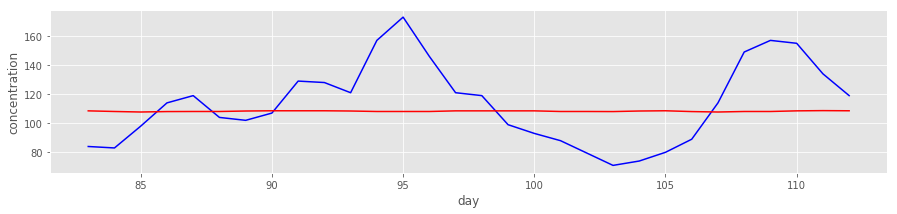

X_train_walk:
   YearMonth        CO      C6H6       NOx  PT08.S5(O3)
0   2004-03  0.346322  0.306103  0.125254     0.449335
1   2004-03  0.386517  0.285561  0.135067     0.316928
y_train_walk:
 0    116.0
1     96.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
83   2004-06  0.310593  0.476581  0.143509     0.430955
84   2004-06  0.185491  0.253535  0.045348     0.278056
y_test_walk:
 83    83.0
84    98.0
Name: NO2(GT)(+4), dtype: float64
labelY:  NO2(GT)(+4)
[1]	valid_0's l2: 759.094	valid_0's l1: 22.2692
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 758.76	valid_0's l1: 22.2647
[3]	valid_0's l2: 758.761	valid_0's l1: 22.2679
[4]	valid_0's l2: 759.094	valid_0's l1: 22.2667
[5]	valid_0's l2: 758.822	valid_0's l1: 22.2676
[6]	valid_0's l2: 758.822	valid_0's l1: 22.2717
[7]	valid_0's l2: 758.772	valid_0's l1: 22.2822
Early stopping, best iteration is:
[2]	valid_0's l2: 758.76	valid_0's l1: 22.264

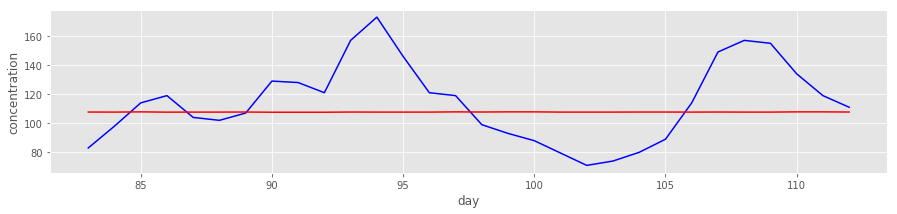

X_train_walk:
   YearMonth        CO      C6H6       NOx  PT08.S5(O3)
0   2004-03  0.346322  0.306103  0.125254     0.449335
1   2004-03  0.386517  0.285561  0.135067     0.316928
y_train_walk:
 0    96.0
1    77.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
83   2004-06  0.310593  0.476581  0.143509     0.430955
84   2004-06  0.185491  0.253535  0.045348     0.278056
y_test_walk:
 83     98.0
84    114.0
Name: NO2(GT)(+5), dtype: float64
labelY:  NO2(GT)(+5)
[1]	valid_0's l2: 745.096	valid_0's l1: 21.6205
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 744.968	valid_0's l1: 21.6256
[3]	valid_0's l2: 745.484	valid_0's l1: 21.6342
[4]	valid_0's l2: 745.658	valid_0's l1: 21.6413
[5]	valid_0's l2: 745.646	valid_0's l1: 21.6444
[6]	valid_0's l2: 745.74	valid_0's l1: 21.6493
Early stopping, best iteration is:
[1]	valid_0's l2: 745.096	valid_0's l1: 21.6205
The rmse of prediction is: 27.296446049648377

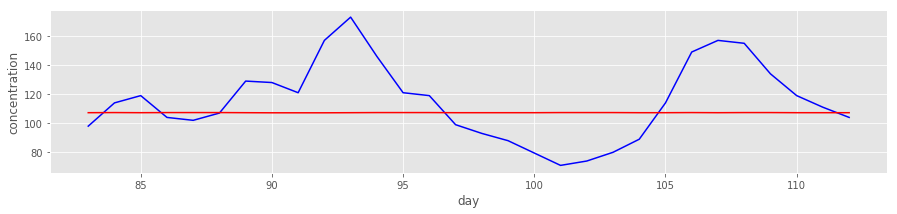

startYearMonth:  2004-04
X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
22   2004-04  0.460005  0.462597  0.156673     0.473698
23   2004-04  0.492486  0.513034  0.147070     0.512803
y_train_walk:
 22    135.0
23    151.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
113   2004-07  0.384487  0.469984  0.129396     0.426412
114   2004-07  0.355660  0.449963  0.138602     0.408694
y_test_walk:
 113    134.0
114    119.0
Name: NO2(GT)(+1), dtype: float64
labelY:  NO2(GT)(+1)
[1]	valid_0's l2: 1349.47	valid_0's l1: 31.1837
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1349.62	valid_0's l1: 31.1894
[3]	valid_0's l2: 1350.36	valid_0's l1: 31.2007
[4]	valid_0's l2: 1351.11	valid_0's l1: 31.2119
[5]	valid_0's l2: 1351.72	valid_0's l1: 31.2273
[6]	valid_0's l2: 1352.57	valid_0's l1: 31.2453
Early stopping, best iteration is:
[1]	valid_0's l2: 1349.47	valid_0's l1: 31.1837
The rms

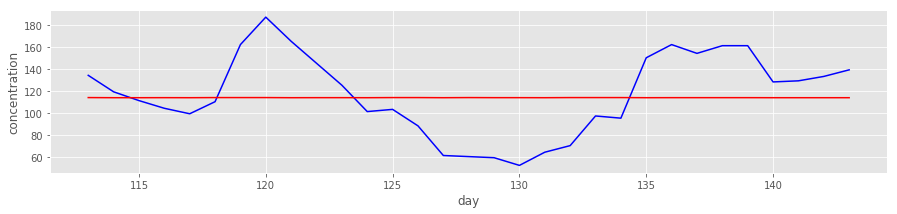

X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
22   2004-04  0.460005  0.462597  0.156673     0.473698
23   2004-04  0.492486  0.513034  0.147070     0.512803
y_train_walk:
 22    151.0
23    172.0
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
113   2004-07  0.384487  0.469984  0.129396     0.426412
114   2004-07  0.355660  0.449963  0.138602     0.408694
y_test_walk:
 113    119.0
114    111.0
Name: NO2(GT)(+2), dtype: float64
labelY:  NO2(GT)(+2)
[1]	valid_0's l2: 1352.65	valid_0's l1: 31.2643
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1351.64	valid_0's l1: 31.2597
[3]	valid_0's l2: 1351.62	valid_0's l1: 31.2639
[4]	valid_0's l2: 1351.61	valid_0's l1: 31.2681
[5]	valid_0's l2: 1351	valid_0's l1: 31.268
[6]	valid_0's l2: 1350.43	valid_0's l1: 31.27
[7]	valid_0's l2: 1349.53	valid_0's l1: 31.2675
Early stopping, best iteration is:
[2]	valid_0's l2: 1351.64	valid_0's l1

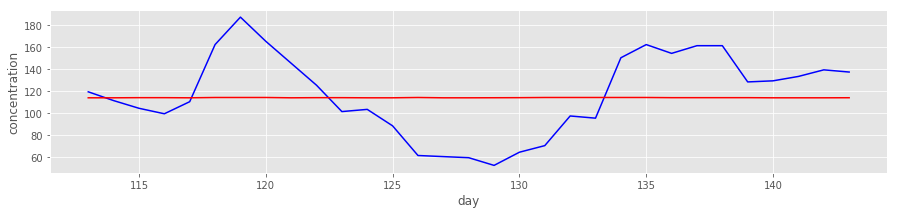

X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
22   2004-04  0.460005  0.462597  0.156673     0.473698
23   2004-04  0.492486  0.513034  0.147070     0.512803
y_train_walk:
 22    172.0
23    165.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
113   2004-07  0.384487  0.469984  0.129396     0.426412
114   2004-07  0.355660  0.449963  0.138602     0.408694
y_test_walk:
 113    111.0
114    104.0
Name: NO2(GT)(+3), dtype: float64
labelY:  NO2(GT)(+3)
[1]	valid_0's l2: 1381.88	valid_0's l1: 32.0412
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1380.34	valid_0's l1: 32.0283
[3]	valid_0's l2: 1380.49	valid_0's l1: 32.0337
[4]	valid_0's l2: 1380.27	valid_0's l1: 32.0329
[5]	valid_0's l2: 1379.11	valid_0's l1: 32.0228
[6]	valid_0's l2: 1377.98	valid_0's l1: 32.0129
[7]	valid_0's l2: 1376.41	valid_0's l1: 31.9998
[8]	valid_0's l2: 1374.85	valid_0's l1: 31.9868
[9]	valid_0's l2: 1

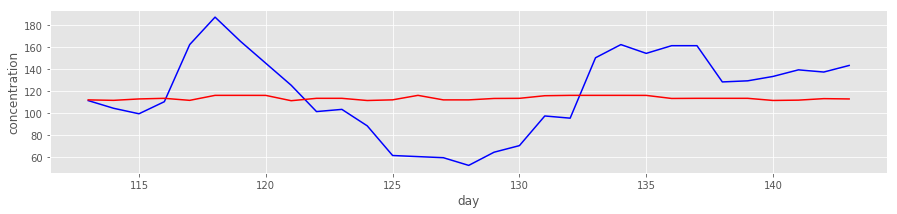

X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
22   2004-04  0.460005  0.462597  0.156673     0.473698
23   2004-04  0.492486  0.513034  0.147070     0.512803
y_train_walk:
 22    165.0
23    136.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
113   2004-07  0.384487  0.469984  0.129396     0.426412
114   2004-07  0.355660  0.449963  0.138602     0.408694
y_test_walk:
 113    104.0
114     99.0
Name: NO2(GT)(+4), dtype: float64
labelY:  NO2(GT)(+4)
[1]	valid_0's l2: 1522.1	valid_0's l1: 34.0855
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1520.69	valid_0's l1: 34.0725
[3]	valid_0's l2: 1520.86	valid_0's l1: 34.0664
[4]	valid_0's l2: 1520.24	valid_0's l1: 34.054
[5]	valid_0's l2: 1519.47	valid_0's l1: 34.0496
[6]	valid_0's l2: 1518.71	valid_0's l1: 34.0453
[7]	valid_0's l2: 1517.07	valid_0's l1: 34.0232
[8]	valid_0's l2: 1515.44	valid_0's l1: 34.0011
[9]	valid_0's l2: 151

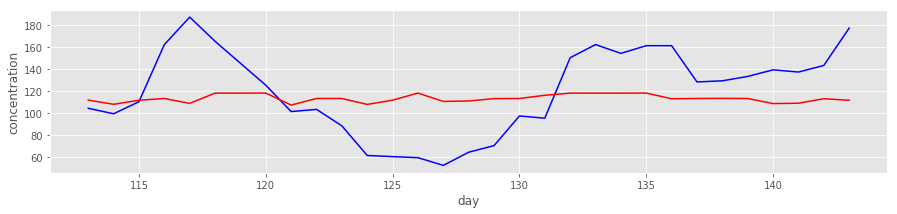

X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
22   2004-04  0.460005  0.462597  0.156673     0.473698
23   2004-04  0.492486  0.513034  0.147070     0.512803
y_train_walk:
 22    136.0
23     85.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
113   2004-07  0.384487  0.469984  0.129396     0.426412
114   2004-07  0.355660  0.449963  0.138602     0.408694
y_test_walk:
 113     99.0
114    110.0
Name: NO2(GT)(+5), dtype: float64
labelY:  NO2(GT)(+5)
[1]	valid_0's l2: 1553.22	valid_0's l1: 34.7377
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1552.52	valid_0's l1: 34.726
[3]	valid_0's l2: 1552.07	valid_0's l1: 34.7174
[4]	valid_0's l2: 1551.46	valid_0's l1: 34.7025
[5]	valid_0's l2: 1550.91	valid_0's l1: 34.6931
[6]	valid_0's l2: 1550.26	valid_0's l1: 34.6829
[7]	valid_0's l2: 1549.68	valid_0's l1: 34.6699
[8]	valid_0's l2: 1549.29	valid_0's l1: 34.6618
[9]	valid_0's l2: 15

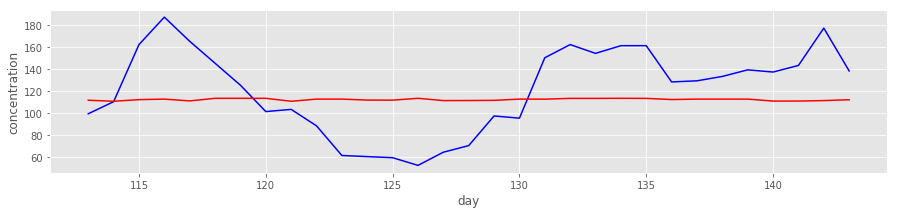

startYearMonth:  2004-05
X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
52   2004-05  0.354848  0.314519  0.088374     0.329105
53   2004-05  0.272428  0.253983  0.077347     0.308688
y_train_walk:
 52    134.0
53    113.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
144   2004-08  0.154685  0.191071  0.022186     0.182227
145   2004-08  0.218023  0.339900  0.064948     0.240832
y_test_walk:
 144    137.0
145    143.0
Name: NO2(GT)(+1), dtype: float64
labelY:  NO2(GT)(+1)
[1]	valid_0's l2: 1442.54	valid_0's l1: 30.2522
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1443.33	valid_0's l1: 30.2676
[3]	valid_0's l2: 1442.92	valid_0's l1: 30.2623
[4]	valid_0's l2: 1443.18	valid_0's l1: 30.2661
[5]	valid_0's l2: 1443.22	valid_0's l1: 30.2627
[6]	valid_0's l2: 1443.52	valid_0's l1: 30.2678
Early stopping, best iteration is:
[1]	valid_0's l2: 1442.54	valid_0's l1: 30.2522
The rms

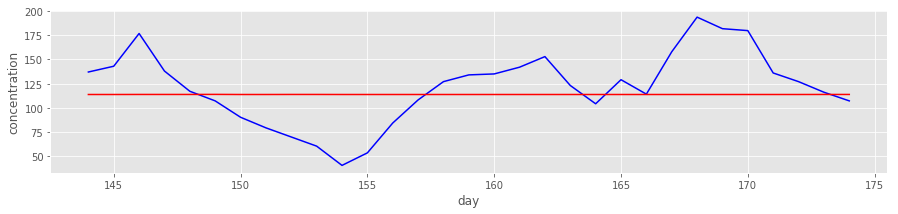

X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
52   2004-05  0.354848  0.314519  0.088374     0.329105
53   2004-05  0.272428  0.253983  0.077347     0.308688
y_train_walk:
 52    113.0
53     97.0
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
144   2004-08  0.154685  0.191071  0.022186     0.182227
145   2004-08  0.218023  0.339900  0.064948     0.240832
y_test_walk:
 144    143.0
145    177.0
Name: NO2(GT)(+2), dtype: float64
labelY:  NO2(GT)(+2)
[1]	valid_0's l2: 1445.63	valid_0's l1: 30.3164
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1445.57	valid_0's l1: 30.3169
[3]	valid_0's l2: 1445.46	valid_0's l1: 30.3184
[4]	valid_0's l2: 1445.35	valid_0's l1: 30.3198
[5]	valid_0's l2: 1445.22	valid_0's l1: 30.3152
[6]	valid_0's l2: 1445.67	valid_0's l1: 30.3238
[7]	valid_0's l2: 1445.71	valid_0's l1: 30.3279
[8]	valid_0's l2: 1445.45	valid_0's l1: 30.3206
[9]	valid_0's l2: 1

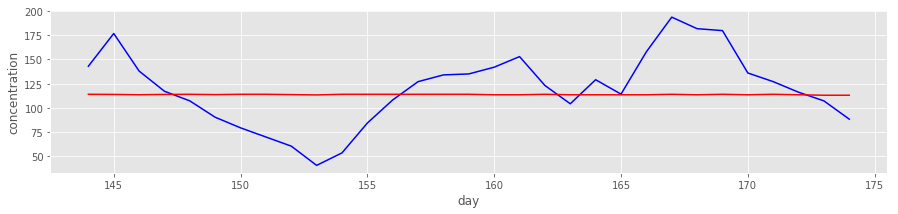

X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
52   2004-05  0.354848  0.314519  0.088374     0.329105
53   2004-05  0.272428  0.253983  0.077347     0.308688
y_train_walk:
 52    97.0
53    82.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
144   2004-08  0.154685  0.191071  0.022186     0.182227
145   2004-08  0.218023  0.339900  0.064948     0.240832
y_test_walk:
 144    177.0
145    138.0
Name: NO2(GT)(+3), dtype: float64
labelY:  NO2(GT)(+3)
[1]	valid_0's l2: 1446.22	valid_0's l1: 30.3125
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1446.24	valid_0's l1: 30.3147
[3]	valid_0's l2: 1445.44	valid_0's l1: 30.3046
[4]	valid_0's l2: 1446.02	valid_0's l1: 30.3111
[5]	valid_0's l2: 1446.02	valid_0's l1: 30.3129
[6]	valid_0's l2: 1447.04	valid_0's l1: 30.3262
[7]	valid_0's l2: 1447.99	valid_0's l1: 30.3381
[8]	valid_0's l2: 1447.8	valid_0's l1: 30.3369
Early stopping, best i

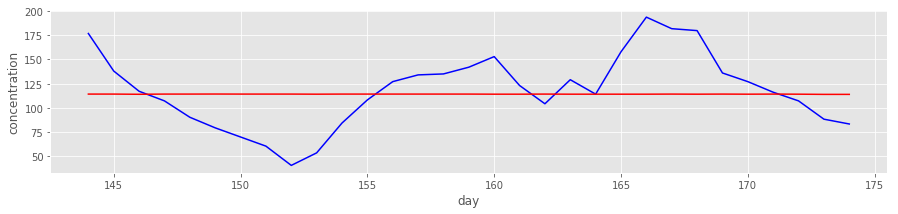

X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
52   2004-05  0.354848  0.314519  0.088374     0.329105
53   2004-05  0.272428  0.253983  0.077347     0.308688
y_train_walk:
 52    82.0
53    82.5
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
144   2004-08  0.154685  0.191071  0.022186     0.182227
145   2004-08  0.218023  0.339900  0.064948     0.240832
y_test_walk:
 144    138.0
145    117.0
Name: NO2(GT)(+4), dtype: float64
labelY:  NO2(GT)(+4)
[1]	valid_0's l2: 1358.53	valid_0's l1: 29.3961
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1358.13	valid_0's l1: 29.3862
[3]	valid_0's l2: 1357.1	valid_0's l1: 29.3678
[4]	valid_0's l2: 1357.39	valid_0's l1: 29.3627
[5]	valid_0's l2: 1357.14	valid_0's l1: 29.3551
[6]	valid_0's l2: 1357.95	valid_0's l1: 29.3568
[7]	valid_0's l2: 1358.75	valid_0's l1: 29.3571
[8]	valid_0's l2: 1358.38	valid_0's l1: 29.3477
Early stopping, best i

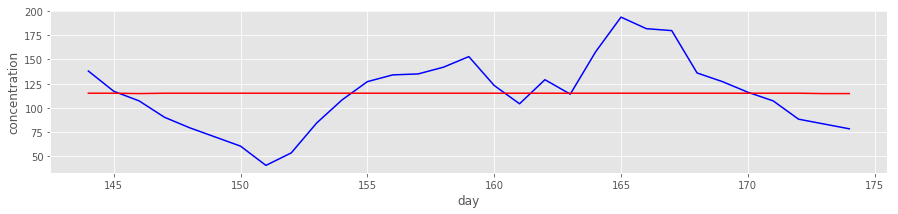

X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
52   2004-05  0.354848  0.314519  0.088374     0.329105
53   2004-05  0.272428  0.253983  0.077347     0.308688
y_train_walk:
 52    82.5
53    83.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
144   2004-08  0.154685  0.191071  0.022186     0.182227
145   2004-08  0.218023  0.339900  0.064948     0.240832
y_test_walk:
 144    117.0
145    107.0
Name: NO2(GT)(+5), dtype: float64
labelY:  NO2(GT)(+5)
[1]	valid_0's l2: 1453.16	valid_0's l1: 30.5405
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1452.58	valid_0's l1: 30.5319
[3]	valid_0's l2: 1451.54	valid_0's l1: 30.5191
[4]	valid_0's l2: 1452.8	valid_0's l1: 30.5216
[5]	valid_0's l2: 1452.29	valid_0's l1: 30.5139
[6]	valid_0's l2: 1453.5	valid_0's l1: 30.5166
[7]	valid_0's l2: 1454.7	valid_0's l1: 30.5149
[8]	valid_0's l2: 1454.19	valid_0's l1: 30.5064
Early stopping, best ite

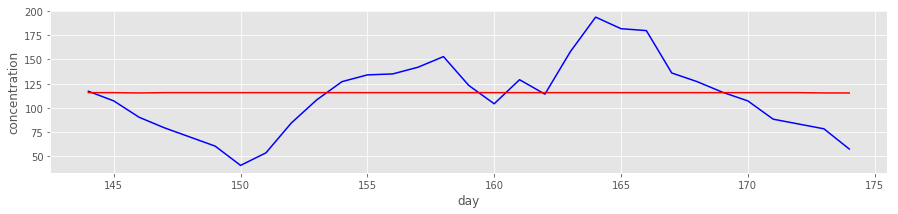

startYearMonth:  2004-06
X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
83   2004-06  0.310593  0.476581  0.143509     0.430955
84   2004-06  0.185491  0.253535  0.045348     0.278056
y_train_walk:
 83    63.0
84    67.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
175   2004-09  0.399104  0.500327  0.275226     0.402467
176   2004-09  0.522252  0.525035  0.344649     0.475121
y_test_walk:
 175    88.0
176    83.0
Name: NO2(GT)(+1), dtype: float64
labelY:  NO2(GT)(+1)
[1]	valid_0's l2: 1772.16	valid_0's l1: 36.1122
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1771.47	valid_0's l1: 36.1164
[3]	valid_0's l2: 1771.83	valid_0's l1: 36.1204
[4]	valid_0's l2: 1772.07	valid_0's l1: 36.1268
[5]	valid_0's l2: 1771.45	valid_0's l1: 36.133
[6]	valid_0's l2: 1770.86	valid_0's l1: 36.1392
Early stopping, best iteration is:
[1]	valid_0's l2: 1772.16	valid_0's l1: 36.1122
The rmse of 

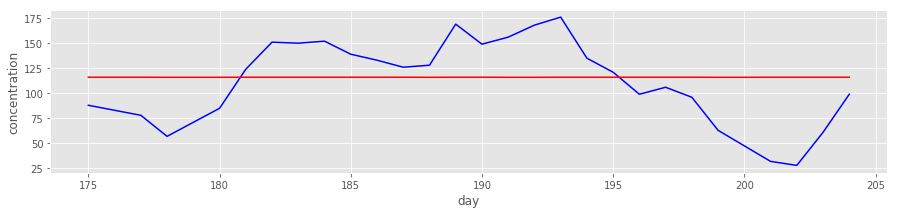

X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
83   2004-06  0.310593  0.476581  0.143509     0.430955
84   2004-06  0.185491  0.253535  0.045348     0.278056
y_train_walk:
 83    67.0
84    84.0
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
175   2004-09  0.399104  0.500327  0.275226     0.402467
176   2004-09  0.522252  0.525035  0.344649     0.475121
y_test_walk:
 175    83.0
176    78.0
Name: NO2(GT)(+2), dtype: float64
labelY:  NO2(GT)(+2)
[1]	valid_0's l2: 1806.09	valid_0's l1: 36.5358
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1806.44	valid_0's l1: 36.5462
[3]	valid_0's l2: 1806.65	valid_0's l1: 36.5523
[4]	valid_0's l2: 1806.52	valid_0's l1: 36.5563
[5]	valid_0's l2: 1807.18	valid_0's l1: 36.5704
[6]	valid_0's l2: 1807.87	valid_0's l1: 36.5805
Early stopping, best iteration is:
[1]	valid_0's l2: 1806.09	valid_0's l1: 36.5358
The rmse of prediction is: 42.498101

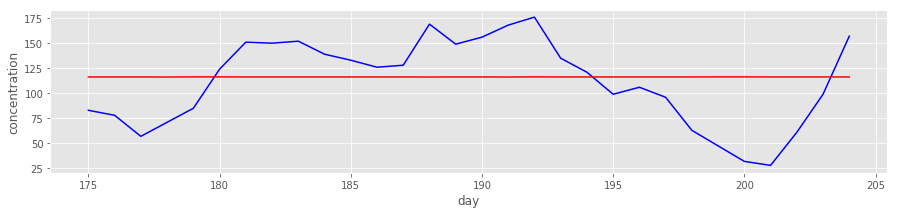

X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
83   2004-06  0.310593  0.476581  0.143509     0.430955
84   2004-06  0.185491  0.253535  0.045348     0.278056
y_train_walk:
 83    84.0
84    83.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
175   2004-09  0.399104  0.500327  0.275226     0.402467
176   2004-09  0.522252  0.525035  0.344649     0.475121
y_test_walk:
 175    78.0
176    57.0
Name: NO2(GT)(+3), dtype: float64
labelY:  NO2(GT)(+3)
[1]	valid_0's l2: 1851.62	valid_0's l1: 37.0533
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1852.27	valid_0's l1: 37.0589
[3]	valid_0's l2: 1852.68	valid_0's l1: 37.063
[4]	valid_0's l2: 1853.09	valid_0's l1: 37.067
[5]	valid_0's l2: 1853.18	valid_0's l1: 37.0684
[6]	valid_0's l2: 1853.27	valid_0's l1: 37.0698
Early stopping, best iteration is:
[1]	valid_0's l2: 1851.62	valid_0's l1: 37.0533
The rmse of prediction is: 43.03046769

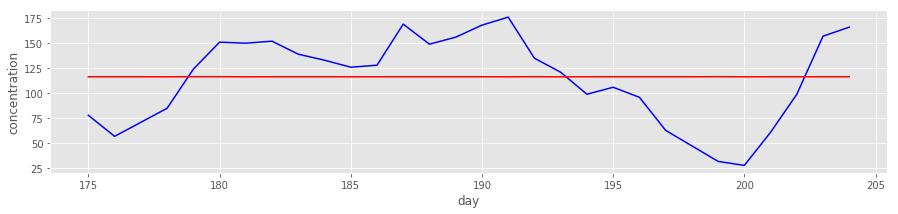

X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
83   2004-06  0.310593  0.476581  0.143509     0.430955
84   2004-06  0.185491  0.253535  0.045348     0.278056
y_train_walk:
 83    83.0
84    98.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
175   2004-09  0.399104  0.500327  0.275226     0.402467
176   2004-09  0.522252  0.525035  0.344649     0.475121
y_test_walk:
 175    57.0
176    71.0
Name: NO2(GT)(+4), dtype: float64
labelY:  NO2(GT)(+4)
[1]	valid_0's l2: 1837.59	valid_0's l1: 36.8701
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1838.28	valid_0's l1: 36.8794
[3]	valid_0's l2: 1838.66	valid_0's l1: 36.8849
[4]	valid_0's l2: 1839.04	valid_0's l1: 36.8903
[5]	valid_0's l2: 1839.32	valid_0's l1: 36.8954
[6]	valid_0's l2: 1839.62	valid_0's l1: 36.9004
Early stopping, best iteration is:
[1]	valid_0's l2: 1837.59	valid_0's l1: 36.8701
The rmse of prediction is: 42.867156

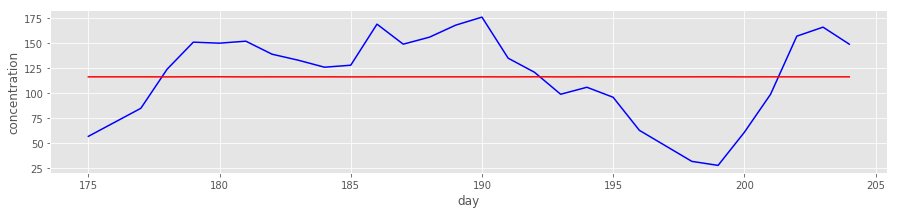

X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
83   2004-06  0.310593  0.476581  0.143509     0.430955
84   2004-06  0.185491  0.253535  0.045348     0.278056
y_train_walk:
 83     98.0
84    114.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
175   2004-09  0.399104  0.500327  0.275226     0.402467
176   2004-09  0.522252  0.525035  0.344649     0.475121
y_test_walk:
 175    71.0
176    85.0
Name: NO2(GT)(+5), dtype: float64
labelY:  NO2(GT)(+5)
[1]	valid_0's l2: 1733.48	valid_0's l1: 35.5953
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1734	valid_0's l1: 35.6087
[3]	valid_0's l2: 1734.72	valid_0's l1: 35.6161
[4]	valid_0's l2: 1734.69	valid_0's l1: 35.6152
[5]	valid_0's l2: 1735.3	valid_0's l1: 35.6122
[6]	valid_0's l2: 1735.91	valid_0's l1: 35.6092
Early stopping, best iteration is:
[1]	valid_0's l2: 1733.48	valid_0's l1: 35.5953
The rmse of prediction is: 41.63506802

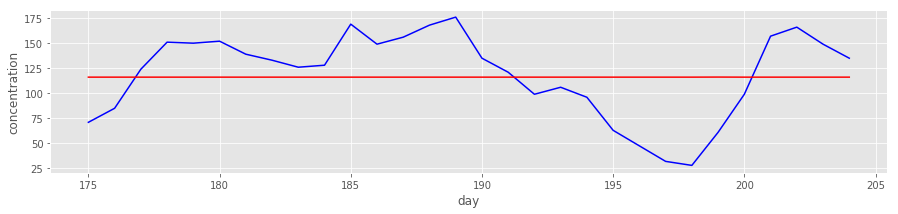

startYearMonth:  2004-07
X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
113   2004-07  0.384487  0.469984  0.129396     0.426412
114   2004-07  0.355660  0.449963  0.138602     0.408694
y_train_walk:
 113    134.0
114    119.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
205   2004-10  0.627310  0.645918  0.449015     0.621381
206   2004-10  0.986332  0.392332  0.597165     0.451669
y_test_walk:
 205    157.0
206    166.0
Name: NO2(GT)(+1), dtype: float64
labelY:  NO2(GT)(+1)
[1]	valid_0's l2: 944.201	valid_0's l1: 25.7435
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 944.501	valid_0's l1: 25.7485
[3]	valid_0's l2: 943.846	valid_0's l1: 25.7385
[4]	valid_0's l2: 943.282	valid_0's l1: 25.7316
[5]	valid_0's l2: 942.833	valid_0's l1: 25.7271
[6]	valid_0's l2: 942.392	valid_0's l1: 25.7226
[7]	valid_0's l2: 941.951	valid_0's l1: 25.718
[8]	valid_0's l2: 941.517	valid_0's l1

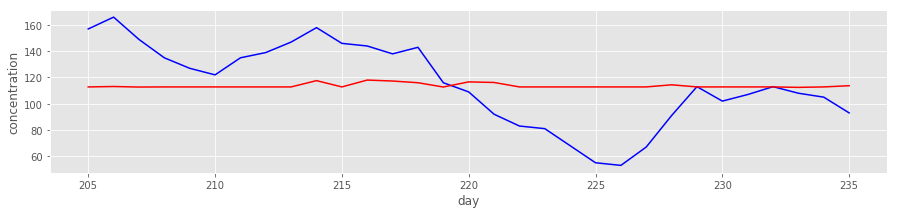

X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
113   2004-07  0.384487  0.469984  0.129396     0.426412
114   2004-07  0.355660  0.449963  0.138602     0.408694
y_train_walk:
 113    119.0
114    111.0
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
205   2004-10  0.627310  0.645918  0.449015     0.621381
206   2004-10  0.986332  0.392332  0.597165     0.451669
y_test_walk:
 205    166.0
206    149.0
Name: NO2(GT)(+2), dtype: float64
labelY:  NO2(GT)(+2)
[1]	valid_0's l2: 918.318	valid_0's l1: 25.3751
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 918.641	valid_0's l1: 25.3765
[3]	valid_0's l2: 917.86	valid_0's l1: 25.3649
[4]	valid_0's l2: 918.033	valid_0's l1: 25.3654
[5]	valid_0's l2: 918.144	valid_0's l1: 25.3664
[6]	valid_0's l2: 918.258	valid_0's l1: 25.3673
[7]	valid_0's l2: 918.517	valid_0's l1: 25.3703
[8]	valid_0's l2: 918.78	valid_0's l1: 25.3732
Early stopping, 

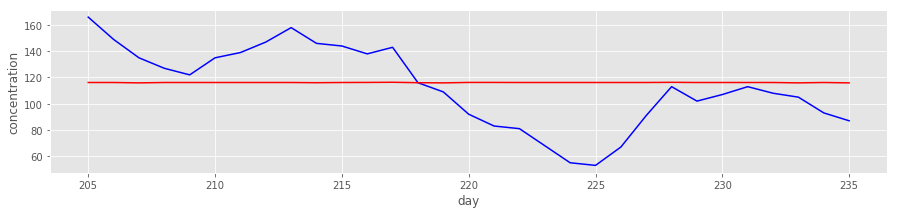

X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
113   2004-07  0.384487  0.469984  0.129396     0.426412
114   2004-07  0.355660  0.449963  0.138602     0.408694
y_train_walk:
 113    111.0
114    104.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
205   2004-10  0.627310  0.645918  0.449015     0.621381
206   2004-10  0.986332  0.392332  0.597165     0.451669
y_test_walk:
 205    149.0
206    135.0
Name: NO2(GT)(+3), dtype: float64
labelY:  NO2(GT)(+3)
[1]	valid_0's l2: 897.16	valid_0's l1: 25.1889
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 897.739	valid_0's l1: 25.1982
[3]	valid_0's l2: 897.12	valid_0's l1: 25.1954
[4]	valid_0's l2: 897.115	valid_0's l1: 25.195
[5]	valid_0's l2: 897.123	valid_0's l1: 25.1949
[6]	valid_0's l2: 897.137	valid_0's l1: 25.1948
Early stopping, best iteration is:
[1]	valid_0's l2: 897.16	valid_0's l1: 25.1889
The rmse of prediction is: 29.9

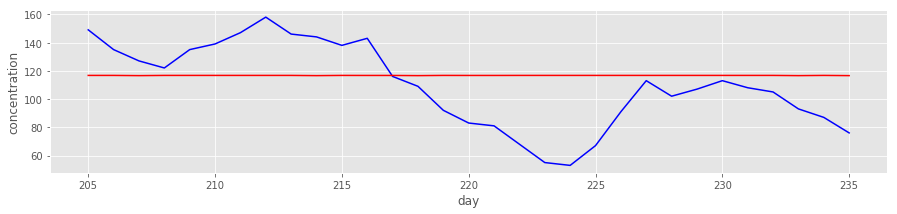

X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
113   2004-07  0.384487  0.469984  0.129396     0.426412
114   2004-07  0.355660  0.449963  0.138602     0.408694
y_train_walk:
 113    104.0
114     99.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
205   2004-10  0.627310  0.645918  0.449015     0.621381
206   2004-10  0.986332  0.392332  0.597165     0.451669
y_test_walk:
 205    135.0
206    127.0
Name: NO2(GT)(+4), dtype: float64
labelY:  NO2(GT)(+4)
[1]	valid_0's l2: 887.21	valid_0's l1: 24.9973
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 887.694	valid_0's l1: 25.0079
[3]	valid_0's l2: 887.131	valid_0's l1: 25.003
[4]	valid_0's l2: 886.574	valid_0's l1: 24.9981
[5]	valid_0's l2: 886.689	valid_0's l1: 25.0033
[6]	valid_0's l2: 886.81	valid_0's l1: 25.0084
Early stopping, best iteration is:
[1]	valid_0's l2: 887.21	valid_0's l1: 24.9973
The rmse of prediction is: 29.7

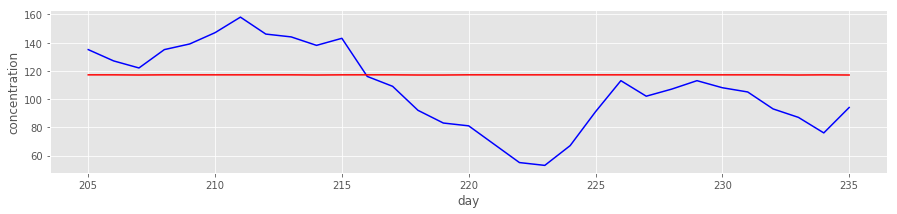

X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
113   2004-07  0.384487  0.469984  0.129396     0.426412
114   2004-07  0.355660  0.449963  0.138602     0.408694
y_train_walk:
 113     99.0
114    110.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
205   2004-10  0.627310  0.645918  0.449015     0.621381
206   2004-10  0.986332  0.392332  0.597165     0.451669
y_test_walk:
 205    127.0
206    122.0
Name: NO2(GT)(+5), dtype: float64
labelY:  NO2(GT)(+5)
[1]	valid_0's l2: 884.588	valid_0's l1: 24.7558
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 885.148	valid_0's l1: 24.7625
[3]	valid_0's l2: 885.293	valid_0's l1: 24.7609
[4]	valid_0's l2: 885.642	valid_0's l1: 24.762
[5]	valid_0's l2: 885.695	valid_0's l1: 24.7601
[6]	valid_0's l2: 885.088	valid_0's l1: 24.7524
Early stopping, best iteration is:
[1]	valid_0's l2: 884.588	valid_0's l1: 24.7558
The rmse of prediction is: 2

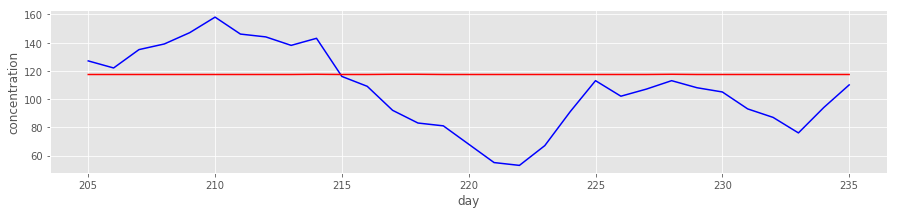

startYearMonth:  2004-08
X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
144   2004-08  0.154685  0.191071  0.022186     0.182227
145   2004-08  0.218023  0.339900  0.064948     0.240832
y_train_walk:
 144    137.0
145    143.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
236   2004-11  0.499388  0.526551  0.369694     0.700072
237   2004-11  0.777100  0.919458  0.571108     0.658832
y_test_walk:
 236    87.0
237    76.0
Name: NO2(GT)(+1), dtype: float64
labelY:  NO2(GT)(+1)
[1]	valid_0's l2: 1115.11	valid_0's l1: 28.02
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1114.71	valid_0's l1: 28.0153
[3]	valid_0's l2: 1114.95	valid_0's l1: 28.0184
[4]	valid_0's l2: 1114.07	valid_0's l1: 28.0091
[5]	valid_0's l2: 1113.77	valid_0's l1: 28.004
[6]	valid_0's l2: 1113.47	valid_0's l1: 27.9989
[7]	valid_0's l2: 1113.2	valid_0's l1: 27.997
[8]	valid_0's l2: 1113.73	valid_0's l1: 28.0

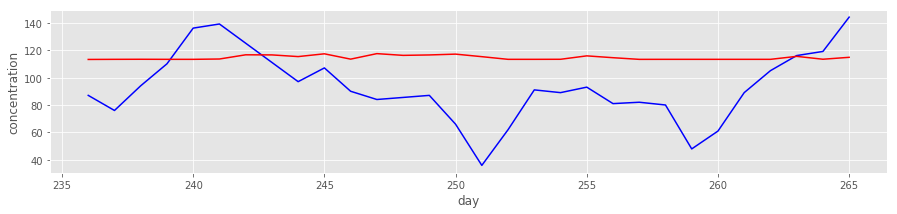

X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
144   2004-08  0.154685  0.191071  0.022186     0.182227
145   2004-08  0.218023  0.339900  0.064948     0.240832
y_train_walk:
 144    143.0
145    177.0
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
236   2004-11  0.499388  0.526551  0.369694     0.700072
237   2004-11  0.777100  0.919458  0.571108     0.658832
y_test_walk:
 236    76.0
237    94.0
Name: NO2(GT)(+2), dtype: float64
labelY:  NO2(GT)(+2)
[1]	valid_0's l2: 1067.95	valid_0's l1: 27.0499
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1067.34	valid_0's l1: 27.0441
[3]	valid_0's l2: 1066.97	valid_0's l1: 27.0413
[4]	valid_0's l2: 1066.52	valid_0's l1: 27.0386
[5]	valid_0's l2: 1065.71	valid_0's l1: 27.0286
[6]	valid_0's l2: 1065.26	valid_0's l1: 27.0216
[7]	valid_0's l2: 1064.57	valid_0's l1: 27.0099
[8]	valid_0's l2: 1063.73	valid_0's l1: 26.9964
[9]	valid_0's l2

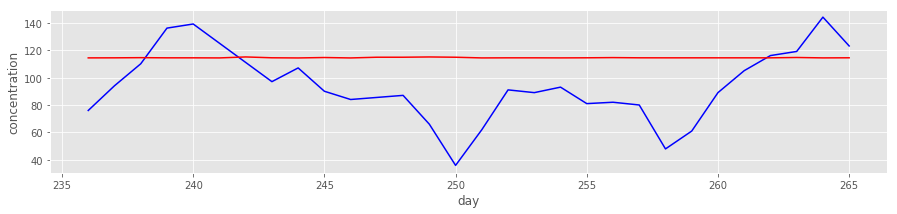

X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
144   2004-08  0.154685  0.191071  0.022186     0.182227
145   2004-08  0.218023  0.339900  0.064948     0.240832
y_train_walk:
 144    177.0
145    138.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
236   2004-11  0.499388  0.526551  0.369694     0.700072
237   2004-11  0.777100  0.919458  0.571108     0.658832
y_test_walk:
 236     94.0
237    110.0
Name: NO2(GT)(+3), dtype: float64
labelY:  NO2(GT)(+3)
[1]	valid_0's l2: 993.934	valid_0's l1: 25.6892
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 993.934	valid_0's l1: 25.6807
[3]	valid_0's l2: 993.413	valid_0's l1: 25.6725
[4]	valid_0's l2: 993.07	valid_0's l1: 25.662
[5]	valid_0's l2: 992.693	valid_0's l1: 25.6496
[6]	valid_0's l2: 993.035	valid_0's l1: 25.6496
[7]	valid_0's l2: 993.059	valid_0's l1: 25.6441
[8]	valid_0's l2: 993.088	valid_0's l1: 25.6386
[9]	valid_0's l2

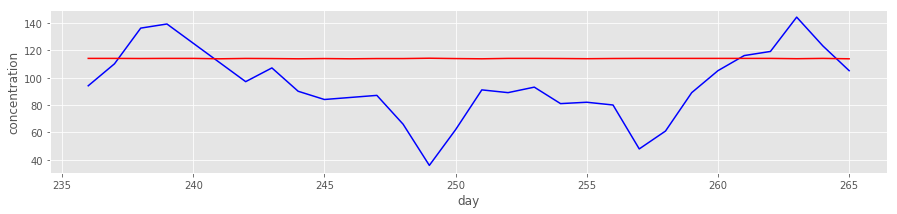

X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
144   2004-08  0.154685  0.191071  0.022186     0.182227
145   2004-08  0.218023  0.339900  0.064948     0.240832
y_train_walk:
 144    138.0
145    117.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
236   2004-11  0.499388  0.526551  0.369694     0.700072
237   2004-11  0.777100  0.919458  0.571108     0.658832
y_test_walk:
 236    110.0
237    136.0
Name: NO2(GT)(+4), dtype: float64
labelY:  NO2(GT)(+4)
[1]	valid_0's l2: 961.939	valid_0's l1: 25.243
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 961.607	valid_0's l1: 25.236
[3]	valid_0's l2: 961.662	valid_0's l1: 25.2382
[4]	valid_0's l2: 961.72	valid_0's l1: 25.2403
[5]	valid_0's l2: 962.014	valid_0's l1: 25.2391
[6]	valid_0's l2: 962.259	valid_0's l1: 25.2397
[7]	valid_0's l2: 962.338	valid_0's l1: 25.2375
Early stopping, best iteration is:
[2]	valid_0's l2: 961.607	vali

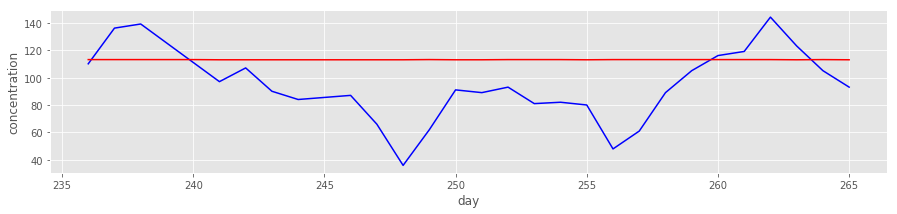

X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
144   2004-08  0.154685  0.191071  0.022186     0.182227
145   2004-08  0.218023  0.339900  0.064948     0.240832
y_train_walk:
 144    117.0
145    107.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
236   2004-11  0.499388  0.526551  0.369694     0.700072
237   2004-11  0.777100  0.919458  0.571108     0.658832
y_test_walk:
 236    136.0
237    139.0
Name: NO2(GT)(+5), dtype: float64
labelY:  NO2(GT)(+5)
[1]	valid_0's l2: 975.848	valid_0's l1: 25.8914
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 975.097	valid_0's l1: 25.8794
[3]	valid_0's l2: 976.271	valid_0's l1: 25.8971
[4]	valid_0's l2: 977.445	valid_0's l1: 25.9146
[5]	valid_0's l2: 977.297	valid_0's l1: 25.9094
[6]	valid_0's l2: 976.876	valid_0's l1: 25.8953
[7]	valid_0's l2: 976.998	valid_0's l1: 25.8922
Early stopping, best iteration is:
[2]	valid_0's l2: 975.097	v

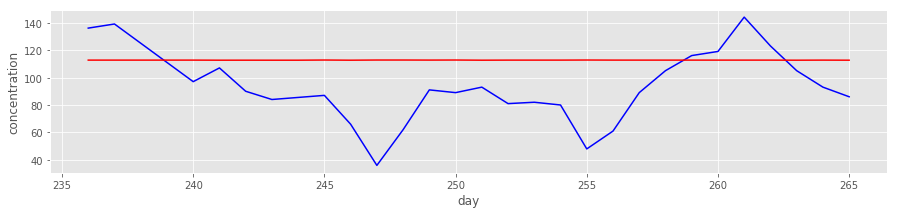

startYearMonth:  2004-09
X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
175   2004-09  0.399104  0.500327  0.275226     0.402467
176   2004-09  0.522252  0.525035  0.344649     0.475121
y_train_walk:
 175    88.0
176    83.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
     YearMonth       CO      C6H6       NOx  PT08.S5(O3)
266   2004-12  0.56841  0.522408  0.596671     0.512176
267   2004-12  0.69874  0.715476  0.706703     0.623960
y_test_walk:
 266    123.0
267    105.0
Name: NO2(GT)(+1), dtype: float64
labelY:  NO2(GT)(+1)
[1]	valid_0's l2: 1415.65	valid_0's l1: 29.5153
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1416.54	valid_0's l1: 29.5238
[3]	valid_0's l2: 1417.06	valid_0's l1: 29.5273
[4]	valid_0's l2: 1417.73	valid_0's l1: 29.5355
[5]	valid_0's l2: 1419.63	valid_0's l1: 29.5501
[6]	valid_0's l2: 1421.53	valid_0's l1: 29.5646
Early stopping, best iteration is:
[1]	valid_0's l2: 1415.65	valid_0's l1: 29.5153
The rms

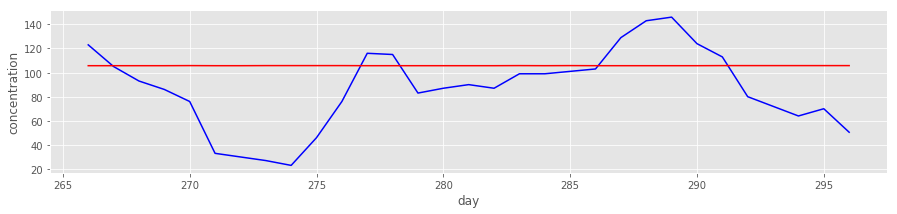

X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
175   2004-09  0.399104  0.500327  0.275226     0.402467
176   2004-09  0.522252  0.525035  0.344649     0.475121
y_train_walk:
 175    83.0
176    78.0
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
     YearMonth       CO      C6H6       NOx  PT08.S5(O3)
266   2004-12  0.56841  0.522408  0.596671     0.512176
267   2004-12  0.69874  0.715476  0.706703     0.623960
y_test_walk:
 266    105.0
267     93.0
Name: NO2(GT)(+2), dtype: float64
labelY:  NO2(GT)(+2)
[1]	valid_0's l2: 1602.98	valid_0's l1: 31.5756
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1603.53	valid_0's l1: 31.5788
[3]	valid_0's l2: 1603.66	valid_0's l1: 31.5763
[4]	valid_0's l2: 1602.65	valid_0's l1: 31.5567
[5]	valid_0's l2: 1604.59	valid_0's l1: 31.5733
[6]	valid_0's l2: 1606.39	valid_0's l1: 31.5932
[7]	valid_0's l2: 1605.96	valid_0's l1: 31.582
[8]	valid_0's l2: 1605.63	valid_0's l1: 31.5784
[9]	valid_0's l2: 16

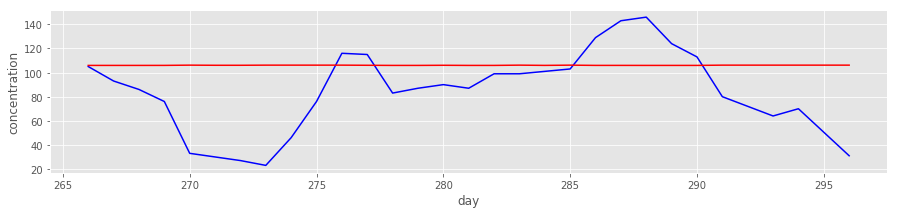

X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
175   2004-09  0.399104  0.500327  0.275226     0.402467
176   2004-09  0.522252  0.525035  0.344649     0.475121
y_train_walk:
 175    78.0
176    57.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
     YearMonth       CO      C6H6       NOx  PT08.S5(O3)
266   2004-12  0.56841  0.522408  0.596671     0.512176
267   2004-12  0.69874  0.715476  0.706703     0.623960
y_test_walk:
 266    93.0
267    86.0
Name: NO2(GT)(+3), dtype: float64
labelY:  NO2(GT)(+3)
[1]	valid_0's l2: 1842.58	valid_0's l1: 34.3841
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1842.31	valid_0's l1: 34.3868
[3]	valid_0's l2: 1841	valid_0's l1: 34.3655
[4]	valid_0's l2: 1840	valid_0's l1: 34.3526
[5]	valid_0's l2: 1840.59	valid_0's l1: 34.3576
[6]	valid_0's l2: 1841.19	valid_0's l1: 34.3624
[7]	valid_0's l2: 1840.83	valid_0's l1: 34.3576
[8]	valid_0's l2: 1840.47	valid_0's l1: 34.3529
[9]	valid_0's l2: 1839.17	v

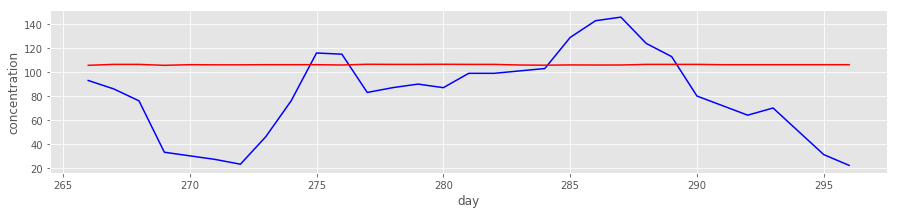

X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
175   2004-09  0.399104  0.500327  0.275226     0.402467
176   2004-09  0.522252  0.525035  0.344649     0.475121
y_train_walk:
 175    57.0
176    71.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
     YearMonth       CO      C6H6       NOx  PT08.S5(O3)
266   2004-12  0.56841  0.522408  0.596671     0.512176
267   2004-12  0.69874  0.715476  0.706703     0.623960
y_test_walk:
 266    86.0
267    76.0
Name: NO2(GT)(+4), dtype: float64
labelY:  NO2(GT)(+4)
[1]	valid_0's l2: 1959.66	valid_0's l1: 35.969
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1959.19	valid_0's l1: 35.9752
[3]	valid_0's l2: 1957.6	valid_0's l1: 35.959
[4]	valid_0's l2: 1957.3	valid_0's l1: 35.968
[5]	valid_0's l2: 1957.09	valid_0's l1: 35.974
[6]	valid_0's l2: 1957.04	valid_0's l1: 35.9838
[7]	valid_0's l2: 1957.85	valid_0's l1: 36.0049
[8]	valid_0's l2: 1958.15	valid_0's l1: 36.0182
Early stopping, best iterat

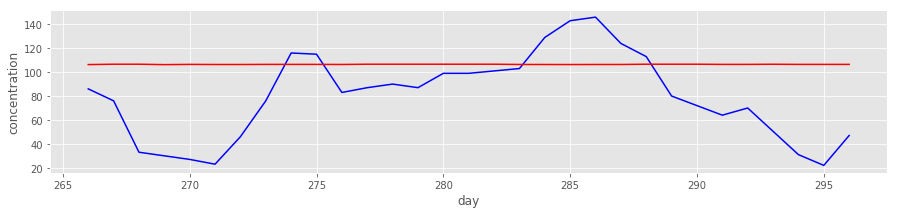

X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
175   2004-09  0.399104  0.500327  0.275226     0.402467
176   2004-09  0.522252  0.525035  0.344649     0.475121
y_train_walk:
 175    71.0
176    85.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
     YearMonth       CO      C6H6       NOx  PT08.S5(O3)
266   2004-12  0.56841  0.522408  0.596671     0.512176
267   2004-12  0.69874  0.715476  0.706703     0.623960
y_test_walk:
 266    76.0
267    33.0
Name: NO2(GT)(+5), dtype: float64
labelY:  NO2(GT)(+5)
[1]	valid_0's l2: 1975.56	valid_0's l1: 36.0932
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 1975.82	valid_0's l1: 36.1139
[3]	valid_0's l2: 1974.4	valid_0's l1: 36.1039
[4]	valid_0's l2: 1975.3	valid_0's l1: 36.1238
[5]	valid_0's l2: 1975.95	valid_0's l1: 36.1473
[6]	valid_0's l2: 1977.22	valid_0's l1: 36.1745
Early stopping, best iteration is:
[1]	valid_0's l2: 1975.56	valid_0's l1: 36.0932
The rmse of prediction is: 44.447238

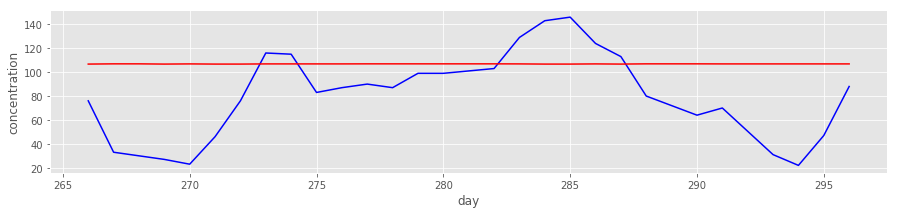

[[29.407155261575635, 28.570714715002552, 27.752346453268853, 27.545591228996784, 27.296446049648377], [36.735096768343425, 36.76461200903331, 36.720129078659575, 38.18950349085688, 39.293768155204745], [37.98074098138395, 38.012829276178394, 38.01899898524422, 36.83880467458595, 38.09906164092435], [42.0970823586985, 42.49810137216814, 43.030467695443356, 42.867156477390274, 41.635068021943056], [30.346154594318325, 30.29620214988948, 29.95262989143588, 29.786072913021243, 29.742030388352095], [32.90450601246609, 32.61485965737551, 31.507035222837846, 31.009788468923382, 31.226549653504243], [37.62517221032271, 40.03312485557483, 42.84386704567733, 44.24478103664255, 44.44723863302267]]


In [19]:
# predict CO concentration
print('Starting training...')

# train
# lightGBM + seq2seq workaround: train 5 models
# validation: walk forward validaiton for time series forcasting
def train_lgbm_model(df_X, df_y, futureYList, evaResList, lgbmModelList):    
    
    month_shift = 3
    
    for startYearMonth in df_X.YearMonth.unique():        
        if startYearMonth.month == 12 - month_shift + 1: # stopping criteria
            break 
        print('startYearMonth: ', startYearMonth)
        iterList = []
        for i, labelY in enumerate(futureYList):
            rangeTrainArr = [x for x in range(startYearMonth.month, startYearMonth.month+month_shift)]
            rangeTestArr = [startYearMonth.month+month_shift]
            rangeTrainPeriodArray = [x for x in df_X.YearMonth.unique() if x.month in rangeTrainArr]
            rangeTestPeriodArray = [x for x in df_X.YearMonth.unique() if x.month in rangeTestArr]
            # segmentaion, use YearMonth as index
            X_train_walk = df_X.loc[df_X.YearMonth.isin(rangeTrainPeriodArray)].copy()
            X_test_walk = df_X.loc[df_X.YearMonth.isin(rangeTestPeriodArray)].copy()        
            y_train_walk = df_y[df_y.index.isin(X_train_walk.index)].copy()
            y_test_walk = df_y[df_y.index.isin(X_test_walk.index)].copy()
            print('X_train_walk:\n', X_train_walk.iloc[:2,:])
            print('y_train_walk:\n', y_train_walk[labelY].iloc[:2])
            print('X_test_walk:\n', X_test_walk.iloc[:2,:])
            print('y_test_walk:\n', y_test_walk[labelY].iloc[:2])
            print('labelY: ', labelY)
            
            X_train_walk.drop(columns=['YearMonth'], inplace=True)
            X_test_walk.drop(columns=['YearMonth'], inplace=True)
            # create dataset for lightgbm                        
            lgb_train = lgb.Dataset(X_train_walk.values, y_train_walk[labelY].values)
            lgb_eval = lgb.Dataset(X_test_walk.values, y_test_walk[labelY].values, reference=lgb_train)    

            # model: share same x parameter, 
            # but y label is future power usage at t+i second
            gbm = lgb.train(params,
                            lgb_train,
                            num_boost_round=800, # num_iterations?
                            valid_sets=lgb_eval,
                            early_stopping_rounds=5)
            # predict
            y_pred = gbm.predict(X_test_walk.values, num_iteration=gbm.best_iteration)
            # eval
            print('The rmse of prediction is:', mean_squared_error(y_test_walk.iloc[:, i].values, y_pred) ** 0.5)             
            iterList.append(mean_squared_error(y_test_walk.iloc[:, i], y_pred) ** 0.5)
            
            # save model to file    
            print('\nSaving model {}...'.format(i))
            modelName = 'lgbmModel' + str(i) + '.txt'
            gbm.save_model(modelName)
            if(startYearMonth.month == 3):
                lgbmModelList.append(modelName)
                
            # plot            
            plt.figure(figsize=(15,3))
            x = X_test_walk.index
            plt.subplot(1, 1, 1)  
            plt.plot(x,y_test_walk.iloc[:, i],'b')
            plt.plot(x,y_pred,'r')            
            plt.xlabel('day')
            plt.ylabel('concentration')
            print ('------------------------------------------------------')
            plt.show()                        
        evaResList.append(iterList)        
    return gbm, lgbmModelList, evaResList
            
lgbmModelList = []                
evaResList = []
gbm, lgbmModelList, evaResList = train_lgbm_model(X_train_norm, y_train, futureYList, lgbmModelList, evaResList)
print(evaResList)

#### evaluates models
* use data range from 2005/01 ~ 2004/02
* as expect, the rmse rise from 1.08 to 1.55 when the time step increase. 

*!!! evaluation method hasn't finished yet !!! # model predict and show result seperately

Starting predicting...

lgbmModelList:  ['lgbmModel0.txt', 'lgbmModel1.txt', 'lgbmModel2.txt', 'lgbmModel3.txt', 'lgbmModel4.txt']
model file: lgbmModel0.txt
         CO      C6H6       NOx  PT08.S5(O3)
0  0.458419  0.342750  0.390219     0.523442
1  0.440853  0.328638  0.418215     0.577390
The rmse of prediction is: 29.367853314455207


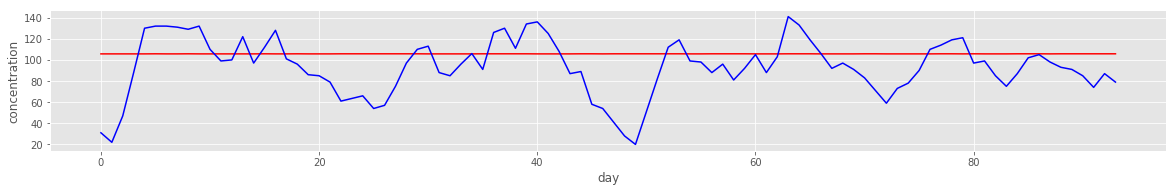

model file: lgbmModel1.txt
         CO      C6H6       NOx  PT08.S5(O3)
0  0.458419  0.342750  0.390219     0.523442
1  0.440853  0.328638  0.418215     0.577390
The rmse of prediction is: 28.642249062121138


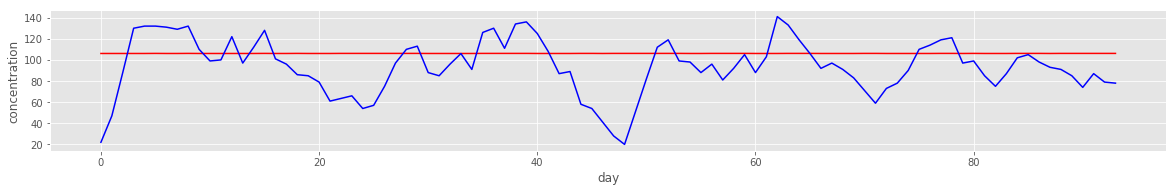

model file: lgbmModel2.txt
         CO      C6H6       NOx  PT08.S5(O3)
0  0.458419  0.342750  0.390219     0.523442
1  0.440853  0.328638  0.418215     0.577390
The rmse of prediction is: 27.64948875447459


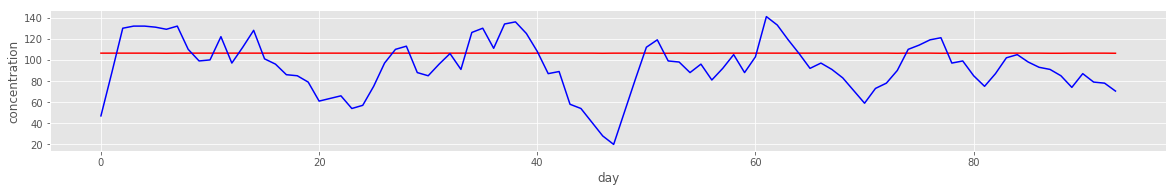

model file: lgbmModel3.txt
         CO      C6H6       NOx  PT08.S5(O3)
0  0.458419  0.342750  0.390219     0.523442
1  0.440853  0.328638  0.418215     0.577390
The rmse of prediction is: 27.396571371938172


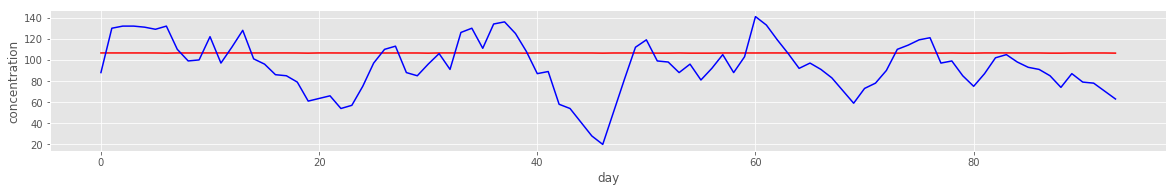

model file: lgbmModel4.txt
         CO      C6H6       NOx  PT08.S5(O3)
0  0.458419  0.342750  0.390219     0.523442
1  0.440853  0.328638  0.418215     0.577390
The rmse of prediction is: 28.137330602132263


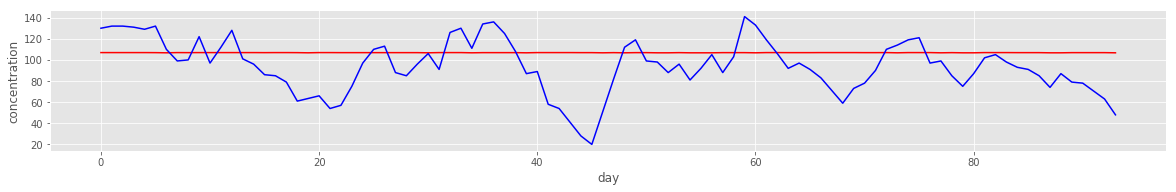

In [20]:
print('Starting predicting...\n')

# model predict and show result seperately
def validation_lgbm_model(df_X, df_y, gbm, lgbmModelList):
    print('lgbmModelList: ', lgbmModelList)
    for i, model in enumerate(lgbmModelList):
        print('model file: {}'.format(model))
        bst = lgb.Booster(model_file = model) # load saved model
        # predict
        X_valid_walk = df_X.drop(columns=['YearMonth']).copy()
        print(X_valid_walk.iloc[:2,:])
        y_pred = bst.predict(X_valid_walk.values, num_iteration=gbm.best_iteration)            

        # eval
        print('The rmse of prediction is:', mean_squared_error(df_y.iloc[:, i], y_pred) ** 0.5)    
        # plot
        plt.figure(figsize=(20,15))            
        x = X_valid_walk.index
        plt.subplot(len(lgbmModelList), 1, 1)   
        plt.plot(x,y_pred,'r')
        plt.plot(x,y_valid.iloc[:, i],'b')
        plt.xlabel('day')
        plt.ylabel('concentration')

        plt.show()
        
validation_lgbm_model(X_valid_norm, y_valid, gbm, lgbmModelList)            

#### RNN model
* RNN with LSTM cells

Reference
* [Neural Network Early Stopping](https://chrisalbon.com/deep_learning/keras/neural_network_early_stopping/)

In [21]:
config = tf.ConfigProto(device_count={"CPU": 8})
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

startYearMonth:  2004-03
X_train_walk:
   YearMonth        CO      C6H6       NOx  PT08.S5(O3)
0   2004-03  0.346322  0.306103  0.125254     0.449335
1   2004-03  0.386517  0.285561  0.135067     0.316928
y_train_walk:
 0     92.0
1    114.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
113   2004-07  0.384487  0.469984  0.129396     0.426412
114   2004-07  0.355660  0.449963  0.138602     0.408694
y_test_walk:
 113    134.0
114    119.0
Name: NO2(GT)(+1), dtype: float64
df_X and df_Y shape: 
 (113, 1, 4) (113, 5)
Train on 113 samples, validate on 31 samples
Epoch 1/50
 - 0s - loss: 109.1199 - val_loss: 117.0160
Epoch 2/50
 - 0s - loss: 109.1143 - val_loss: 117.0107
Epoch 3/50
 - 0s - loss: 109.1085 - val_loss: 117.0051
Epoch 4/50
 - 0s - loss: 109.1025 - val_loss: 116.9994
Epoch 5/50
 - 0s - loss: 109.0961 - val_loss: 116.9932
Epoch 6/50
 - 0s - loss: 109.0895 - val_loss: 116.9867
Epoch 7/50
 - 0s - loss: 109.0826 - val_loss: 

<Figure size 720x360 with 0 Axes>

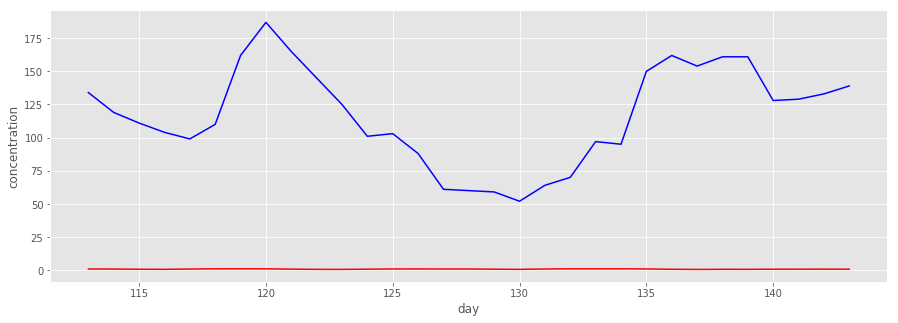

#---------------------------------------#
X_train_walk:
   YearMonth        CO      C6H6       NOx  PT08.S5(O3)
0   2004-03  0.346322  0.306103  0.125254     0.449335
1   2004-03  0.386517  0.285561  0.135067     0.316928
y_train_walk:
 0    114.0
1    122.0
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
113   2004-07  0.384487  0.469984  0.129396     0.426412
114   2004-07  0.355660  0.449963  0.138602     0.408694
y_test_walk:
 113    119.0
114    111.0
Name: NO2(GT)(+2), dtype: float64
df_X and df_Y shape: 
 (113, 1, 4) (113, 5)
Train on 113 samples, validate on 31 samples
Epoch 1/50
 - 1s - loss: 109.4045 - val_loss: 117.0268
Epoch 2/50
 - 0s - loss: 109.3940 - val_loss: 117.0162
Epoch 3/50
 - 0s - loss: 109.3831 - val_loss: 117.0054
Epoch 4/50
 - 0s - loss: 109.3720 - val_loss: 116.9942
Epoch 5/50
 - 0s - loss: 109.3605 - val_loss: 116.9826
Epoch 6/50
 - 0s - loss: 109.3487 - val_loss: 116.9707
Epoch 7/50
 - 0s - loss: 109.

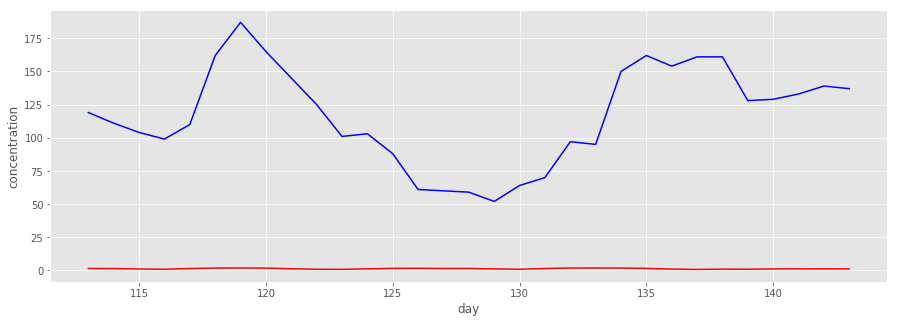

#---------------------------------------#
X_train_walk:
   YearMonth        CO      C6H6       NOx  PT08.S5(O3)
0   2004-03  0.346322  0.306103  0.125254     0.449335
1   2004-03  0.386517  0.285561  0.135067     0.316928
y_train_walk:
 0    122.0
1    116.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
113   2004-07  0.384487  0.469984  0.129396     0.426412
114   2004-07  0.355660  0.449963  0.138602     0.408694
y_test_walk:
 113    111.0
114    104.0
Name: NO2(GT)(+3), dtype: float64
df_X and df_Y shape: 
 (113, 1, 4) (113, 5)
Train on 113 samples, validate on 31 samples
Epoch 1/50
 - 1s - loss: 109.5240 - val_loss: 117.8783
Epoch 2/50
 - 0s - loss: 109.5145 - val_loss: 117.8688
Epoch 3/50
 - 0s - loss: 109.5051 - val_loss: 117.8596
Epoch 4/50
 - 0s - loss: 109.4960 - val_loss: 117.8506
Epoch 5/50
 - 0s - loss: 109.4870 - val_loss: 117.8417
Epoch 6/50
 - 0s - loss: 109.4780 - val_loss: 117.8328
Epoch 7/50
 - 0s - loss: 109.

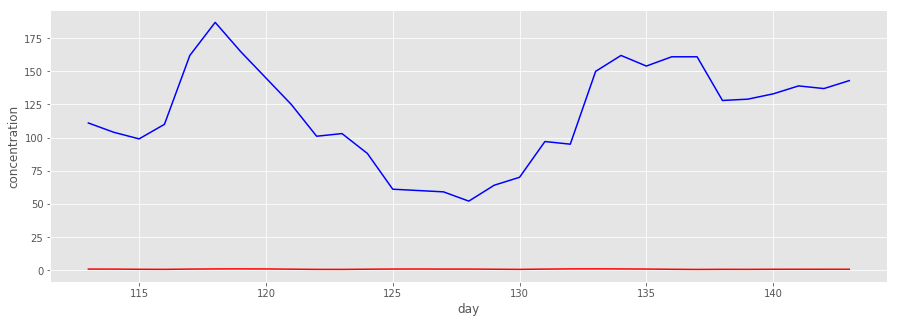

#---------------------------------------#
X_train_walk:
   YearMonth        CO      C6H6       NOx  PT08.S5(O3)
0   2004-03  0.346322  0.306103  0.125254     0.449335
1   2004-03  0.386517  0.285561  0.135067     0.316928
y_train_walk:
 0    116.0
1     96.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
113   2004-07  0.384487  0.469984  0.129396     0.426412
114   2004-07  0.355660  0.449963  0.138602     0.408694
y_test_walk:
 113    104.0
114     99.0
Name: NO2(GT)(+4), dtype: float64
df_X and df_Y shape: 
 (113, 1, 4) (113, 5)
Train on 113 samples, validate on 31 samples
Epoch 1/50
 - 1s - loss: 109.4724 - val_loss: 120.0452
Epoch 2/50
 - 0s - loss: 109.4639 - val_loss: 120.0362
Epoch 3/50
 - 0s - loss: 109.4551 - val_loss: 120.0273
Epoch 4/50
 - 0s - loss: 109.4464 - val_loss: 120.0186
Epoch 5/50
 - 0s - loss: 109.4377 - val_loss: 120.0098
Epoch 6/50
 - 0s - loss: 109.4289 - val_loss: 120.0010
Epoch 7/50
 - 0s - loss: 109.

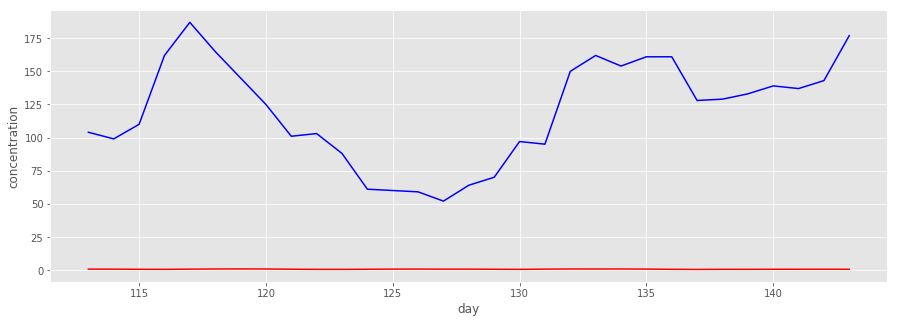

#---------------------------------------#
X_train_walk:
   YearMonth        CO      C6H6       NOx  PT08.S5(O3)
0   2004-03  0.346322  0.306103  0.125254     0.449335
1   2004-03  0.386517  0.285561  0.135067     0.316928
y_train_walk:
 0    96.0
1    77.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
113   2004-07  0.384487  0.469984  0.129396     0.426412
114   2004-07  0.355660  0.449963  0.138602     0.408694
y_test_walk:
 113     99.0
114    110.0
Name: NO2(GT)(+5), dtype: float64
df_X and df_Y shape: 
 (113, 1, 4) (113, 5)
Train on 113 samples, validate on 31 samples
Epoch 1/50
 - 1s - loss: 109.3660 - val_loss: 121.1393
Epoch 2/50
 - 0s - loss: 109.3571 - val_loss: 121.1307
Epoch 3/50
 - 0s - loss: 109.3485 - val_loss: 121.1223
Epoch 4/50
 - 0s - loss: 109.3400 - val_loss: 121.1141
Epoch 5/50
 - 0s - loss: 109.3316 - val_loss: 121.1060
Epoch 6/50
 - 0s - loss: 109.3233 - val_loss: 121.0979
Epoch 7/50
 - 0s - loss: 109.31

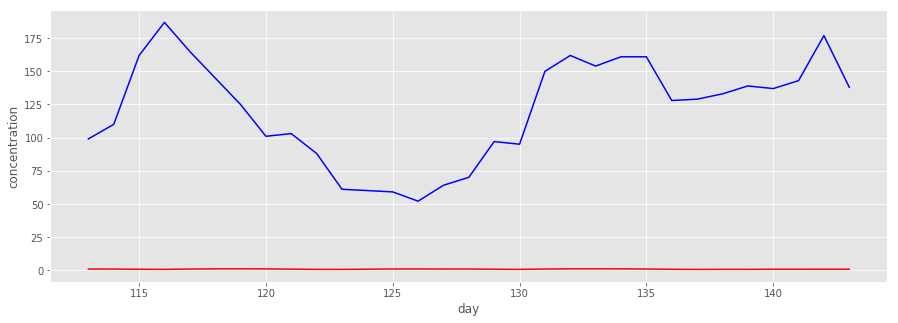

#---------------------------------------#
startYearMonth:  2004-04
X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
22   2004-04  0.460005  0.462597  0.156673     0.473698
23   2004-04  0.492486  0.513034  0.147070     0.512803
y_train_walk:
 22    135.0
23    151.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
144   2004-08  0.154685  0.191071  0.022186     0.182227
145   2004-08  0.218023  0.339900  0.064948     0.240832
y_test_walk:
 144    137.0
145    143.0
Name: NO2(GT)(+1), dtype: float64
df_X and df_Y shape: 
 (122, 1, 4) (122, 5)
Train on 122 samples, validate on 31 samples
Epoch 1/50
 - 1s - loss: 114.5434 - val_loss: 121.4055
Epoch 2/50
 - 0s - loss: 114.5354 - val_loss: 121.3986
Epoch 3/50
 - 0s - loss: 114.5274 - val_loss: 121.3917
Epoch 4/50
 - 0s - loss: 114.5194 - val_loss: 121.3848
Epoch 5/50
 - 0s - loss: 114.5114 - val_loss: 121.3780
Epoch 6/50
 - 0s - loss: 114.5035 - val_loss: 121.3711

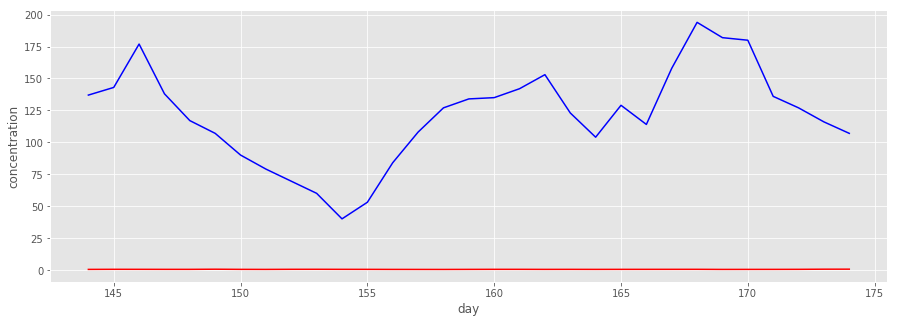

#---------------------------------------#
X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
22   2004-04  0.460005  0.462597  0.156673     0.473698
23   2004-04  0.492486  0.513034  0.147070     0.512803
y_train_walk:
 22    151.0
23    172.0
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
144   2004-08  0.154685  0.191071  0.022186     0.182227
145   2004-08  0.218023  0.339900  0.064948     0.240832
y_test_walk:
 144    143.0
145    177.0
Name: NO2(GT)(+2), dtype: float64
df_X and df_Y shape: 
 (122, 1, 4) (122, 5)
Train on 122 samples, validate on 31 samples
Epoch 1/50
 - 1s - loss: 114.5241 - val_loss: 119.8030
Epoch 2/50
 - 0s - loss: 114.5179 - val_loss: 119.7973
Epoch 3/50
 - 0s - loss: 114.5115 - val_loss: 119.7915
Epoch 4/50
 - 0s - loss: 114.5050 - val_loss: 119.7857
Epoch 5/50
 - 0s - loss: 114.4984 - val_loss: 119.7798
Epoch 6/50
 - 0s - loss: 114.4917 - val_loss: 119.7738
Epoch 7/50
 - 0s - loss:

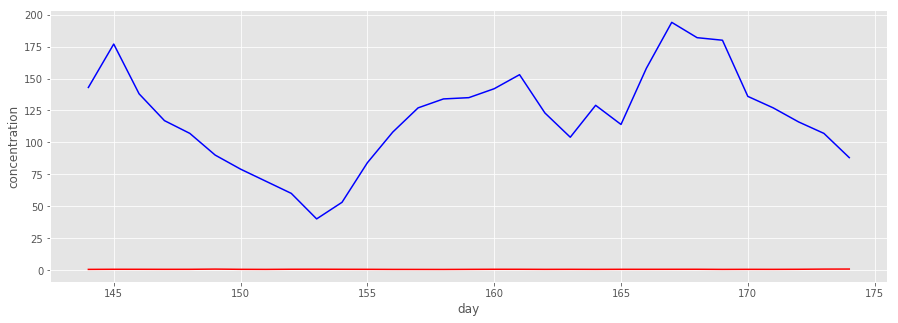

#---------------------------------------#
X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
22   2004-04  0.460005  0.462597  0.156673     0.473698
23   2004-04  0.492486  0.513034  0.147070     0.512803
y_train_walk:
 22    172.0
23    165.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
144   2004-08  0.154685  0.191071  0.022186     0.182227
145   2004-08  0.218023  0.339900  0.064948     0.240832
y_test_walk:
 144    177.0
145    138.0
Name: NO2(GT)(+3), dtype: float64
df_X and df_Y shape: 
 (122, 1, 4) (122, 5)
Train on 122 samples, validate on 31 samples
Epoch 1/50
 - 1s - loss: 114.5223 - val_loss: 117.9056
Epoch 2/50
 - 0s - loss: 114.5129 - val_loss: 117.8977
Epoch 3/50
 - 0s - loss: 114.5038 - val_loss: 117.8900
Epoch 4/50
 - 0s - loss: 114.4947 - val_loss: 117.8826
Epoch 5/50
 - 0s - loss: 114.4857 - val_loss: 117.8755
Epoch 6/50
 - 0s - loss: 114.4770 - val_loss: 117.8688
Epoch 7/50
 - 0s - loss:

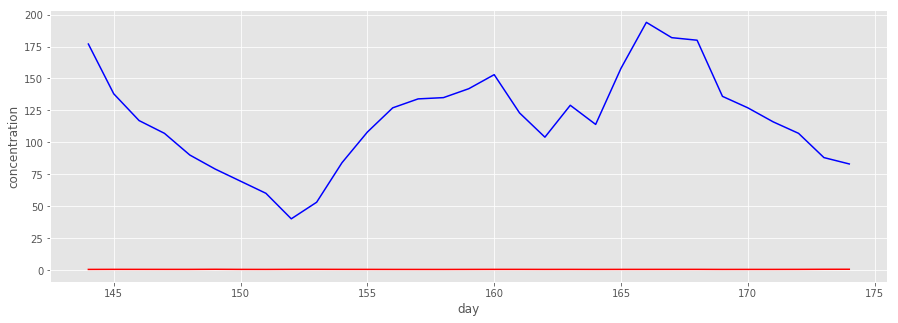

#---------------------------------------#
X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
22   2004-04  0.460005  0.462597  0.156673     0.473698
23   2004-04  0.492486  0.513034  0.147070     0.512803
y_train_walk:
 22    165.0
23    136.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
144   2004-08  0.154685  0.191071  0.022186     0.182227
145   2004-08  0.218023  0.339900  0.064948     0.240832
y_test_walk:
 144    138.0
145    117.0
Name: NO2(GT)(+4), dtype: float64
df_X and df_Y shape: 
 (122, 1, 4) (122, 5)
Train on 122 samples, validate on 31 samples
Epoch 1/50
 - 1s - loss: 114.5375 - val_loss: 114.6967
Epoch 2/50
 - 0s - loss: 114.5271 - val_loss: 114.6878
Epoch 3/50
 - 0s - loss: 114.5167 - val_loss: 114.6789
Epoch 4/50
 - 0s - loss: 114.5065 - val_loss: 114.6703
Epoch 5/50
 - 0s - loss: 114.4963 - val_loss: 114.6618
Epoch 6/50
 - 0s - loss: 114.4863 - val_loss: 114.6534
Epoch 7/50
 - 0s - loss:

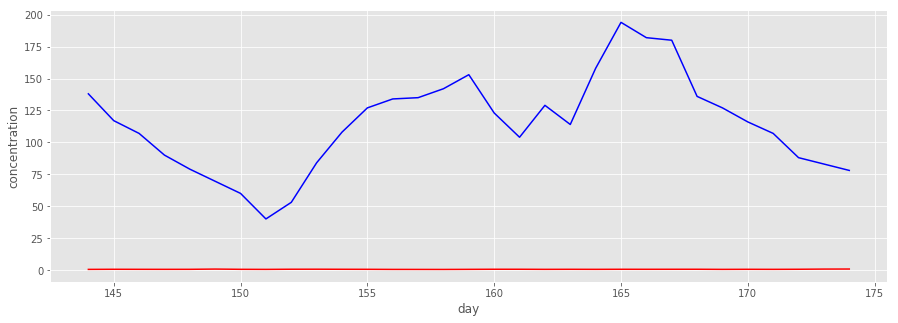

#---------------------------------------#
X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
22   2004-04  0.460005  0.462597  0.156673     0.473698
23   2004-04  0.492486  0.513034  0.147070     0.512803
y_train_walk:
 22    136.0
23     85.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
144   2004-08  0.154685  0.191071  0.022186     0.182227
145   2004-08  0.218023  0.339900  0.064948     0.240832
y_test_walk:
 144    117.0
145    107.0
Name: NO2(GT)(+5), dtype: float64
df_X and df_Y shape: 
 (122, 1, 4) (122, 5)
Train on 122 samples, validate on 31 samples
Epoch 1/50
 - 2s - loss: 114.2923 - val_loss: 112.0700
Epoch 2/50
 - 0s - loss: 114.2862 - val_loss: 112.0644
Epoch 3/50
 - 0s - loss: 114.2801 - val_loss: 112.0587
Epoch 4/50
 - 0s - loss: 114.2739 - val_loss: 112.0530
Epoch 5/50
 - 0s - loss: 114.2675 - val_loss: 112.0473
Epoch 6/50
 - 0s - loss: 114.2611 - val_loss: 112.0414
Epoch 7/50
 - 0s - loss:

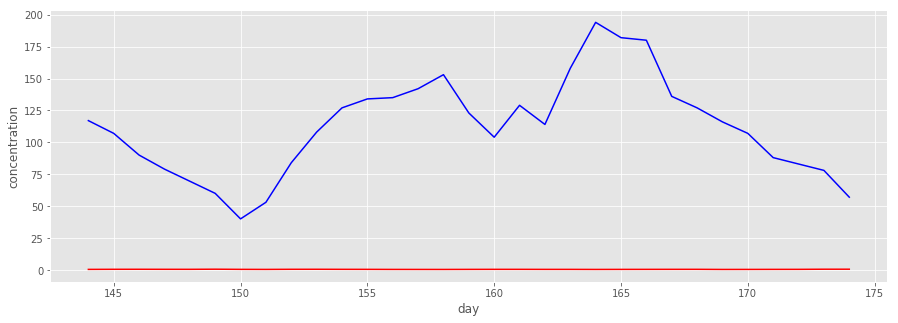

#---------------------------------------#
startYearMonth:  2004-05
X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
52   2004-05  0.354848  0.314519  0.088374     0.329105
53   2004-05  0.272428  0.253983  0.077347     0.308688
y_train_walk:
 52    134.0
53    113.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
175   2004-09  0.399104  0.500327  0.275226     0.402467
176   2004-09  0.522252  0.525035  0.344649     0.475121
y_test_walk:
 175    88.0
176    83.0
Name: NO2(GT)(+1), dtype: float64
df_X and df_Y shape: 
 (123, 1, 4) (123, 5)
Train on 123 samples, validate on 30 samples
Epoch 1/50
 - 2s - loss: 115.6180 - val_loss: 108.9853
Epoch 2/50
 - 0s - loss: 115.6104 - val_loss: 108.9763
Epoch 3/50
 - 0s - loss: 115.6030 - val_loss: 108.9678
Epoch 4/50
 - 0s - loss: 115.5959 - val_loss: 108.9596
Epoch 5/50
 - 0s - loss: 115.5890 - val_loss: 108.9519
Epoch 6/50
 - 0s - loss: 115.5824 - val_loss: 108.9443
E

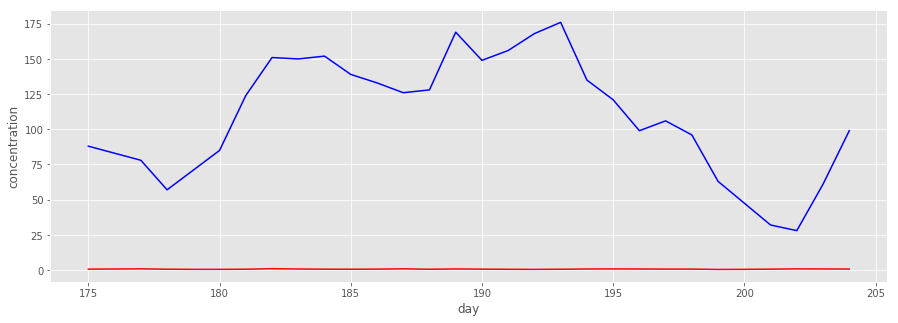

#---------------------------------------#
X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
52   2004-05  0.354848  0.314519  0.088374     0.329105
53   2004-05  0.272428  0.253983  0.077347     0.308688
y_train_walk:
 52    113.0
53     97.0
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
175   2004-09  0.399104  0.500327  0.275226     0.402467
176   2004-09  0.522252  0.525035  0.344649     0.475121
y_test_walk:
 175    83.0
176    78.0
Name: NO2(GT)(+2), dtype: float64
df_X and df_Y shape: 
 (123, 1, 4) (123, 5)
Train on 123 samples, validate on 30 samples
Epoch 1/50
 - 2s - loss: 115.2818 - val_loss: 111.3176
Epoch 2/50
 - 0s - loss: 115.2714 - val_loss: 111.3051
Epoch 3/50
 - 0s - loss: 115.2607 - val_loss: 111.2926
Epoch 4/50
 - 0s - loss: 115.2500 - val_loss: 111.2800
Epoch 5/50
 - 0s - loss: 115.2392 - val_loss: 111.2672
Epoch 6/50
 - 0s - loss: 115.2283 - val_loss: 111.2542
Epoch 7/50
 - 0s - loss: 1

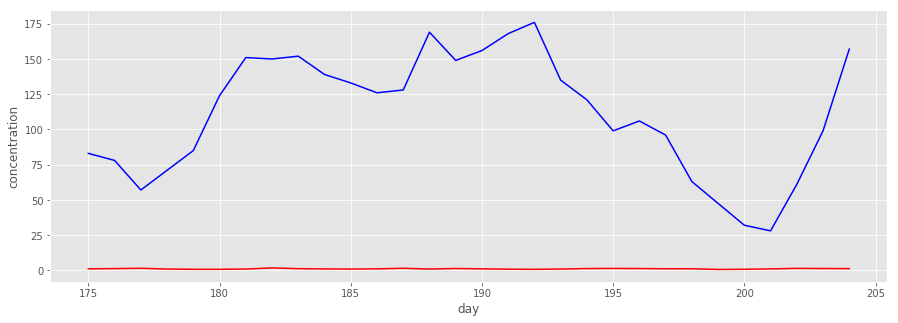

#---------------------------------------#
X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
52   2004-05  0.354848  0.314519  0.088374     0.329105
53   2004-05  0.272428  0.253983  0.077347     0.308688
y_train_walk:
 52    97.0
53    82.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
175   2004-09  0.399104  0.500327  0.275226     0.402467
176   2004-09  0.522252  0.525035  0.344649     0.475121
y_test_walk:
 175    78.0
176    57.0
Name: NO2(GT)(+3), dtype: float64
df_X and df_Y shape: 
 (123, 1, 4) (123, 5)
Train on 123 samples, validate on 30 samples
Epoch 1/50
 - 2s - loss: 115.0529 - val_loss: 114.1122
Epoch 2/50
 - 0s - loss: 115.0429 - val_loss: 114.1005
Epoch 3/50
 - 0s - loss: 115.0332 - val_loss: 114.0892
Epoch 4/50
 - 0s - loss: 115.0239 - val_loss: 114.0784
Epoch 5/50
 - 0s - loss: 115.0151 - val_loss: 114.0682
Epoch 6/50
 - 0s - loss: 115.0068 - val_loss: 114.0585
Epoch 7/50
 - 0s - loss: 114

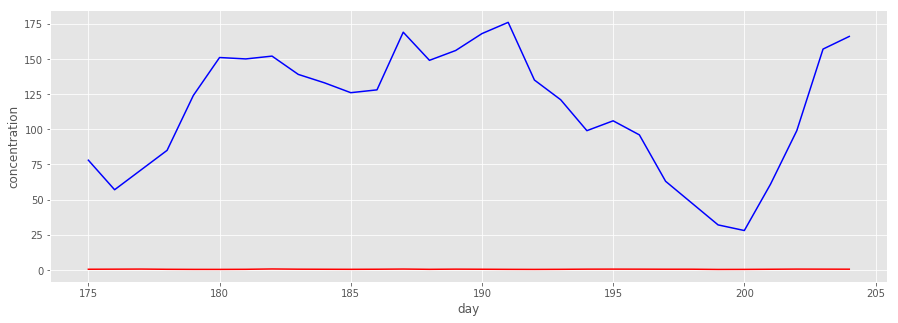

#---------------------------------------#
X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
52   2004-05  0.354848  0.314519  0.088374     0.329105
53   2004-05  0.272428  0.253983  0.077347     0.308688
y_train_walk:
 52    82.0
53    82.5
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
175   2004-09  0.399104  0.500327  0.275226     0.402467
176   2004-09  0.522252  0.525035  0.344649     0.475121
y_test_walk:
 175    57.0
176    71.0
Name: NO2(GT)(+4), dtype: float64
df_X and df_Y shape: 
 (123, 1, 4) (123, 5)
Train on 123 samples, validate on 30 samples
Epoch 1/50
 - 2s - loss: 114.8783 - val_loss: 116.4823
Epoch 2/50
 - 0s - loss: 114.8720 - val_loss: 116.4753
Epoch 3/50
 - 0s - loss: 114.8659 - val_loss: 116.4684
Epoch 4/50
 - 0s - loss: 114.8597 - val_loss: 116.4616
Epoch 5/50
 - 0s - loss: 114.8537 - val_loss: 116.4549
Epoch 6/50
 - 0s - loss: 114.8477 - val_loss: 116.4484
Epoch 7/50
 - 0s - loss: 114

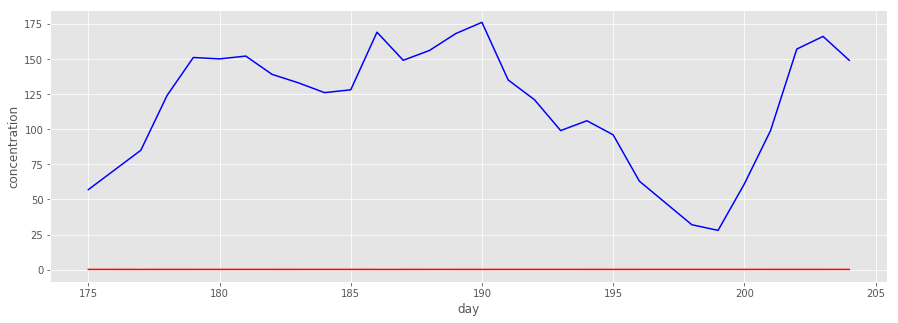

#---------------------------------------#
X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
52   2004-05  0.354848  0.314519  0.088374     0.329105
53   2004-05  0.272428  0.253983  0.077347     0.308688
y_train_walk:
 52    82.5
53    83.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
175   2004-09  0.399104  0.500327  0.275226     0.402467
176   2004-09  0.522252  0.525035  0.344649     0.475121
y_test_walk:
 175    71.0
176    85.0
Name: NO2(GT)(+5), dtype: float64
df_X and df_Y shape: 
 (123, 1, 4) (123, 5)
Train on 123 samples, validate on 30 samples
Epoch 1/50
 - 3s - loss: 114.6717 - val_loss: 119.0776
Epoch 2/50
 - 0s - loss: 114.6630 - val_loss: 119.0677
Epoch 3/50
 - 0s - loss: 114.6542 - val_loss: 119.0577
Epoch 4/50
 - 0s - loss: 114.6454 - val_loss: 119.0477
Epoch 5/50
 - 0s - loss: 114.6364 - val_loss: 119.0374
Epoch 6/50
 - 0s - loss: 114.6273 - val_loss: 119.0270
Epoch 7/50
 - 0s - loss: 114

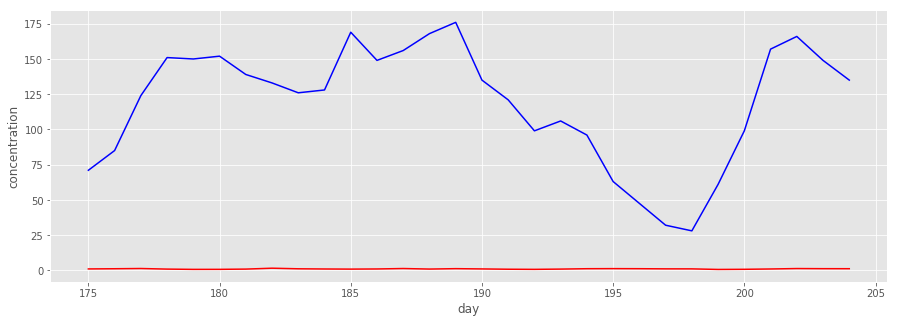

#---------------------------------------#
startYearMonth:  2004-06
X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
83   2004-06  0.310593  0.476581  0.143509     0.430955
84   2004-06  0.185491  0.253535  0.045348     0.278056
y_train_walk:
 83    63.0
84    67.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
205   2004-10  0.627310  0.645918  0.449015     0.621381
206   2004-10  0.986332  0.392332  0.597165     0.451669
y_test_walk:
 205    157.0
206    166.0
Name: NO2(GT)(+1), dtype: float64
df_X and df_Y shape: 
 (122, 1, 4) (122, 5)
Train on 122 samples, validate on 31 samples
Epoch 1/50
 - 3s - loss: 114.3148 - val_loss: 114.8992
Epoch 2/50
 - 0s - loss: 114.3088 - val_loss: 114.8925
Epoch 3/50
 - 0s - loss: 114.3027 - val_loss: 114.8858
Epoch 4/50
 - 0s - loss: 114.2967 - val_loss: 114.8792
Epoch 5/50
 - 0s - loss: 114.2907 - val_loss: 114.8725
Epoch 6/50
 - 0s - loss: 114.2846 - val_loss: 114.8659
E

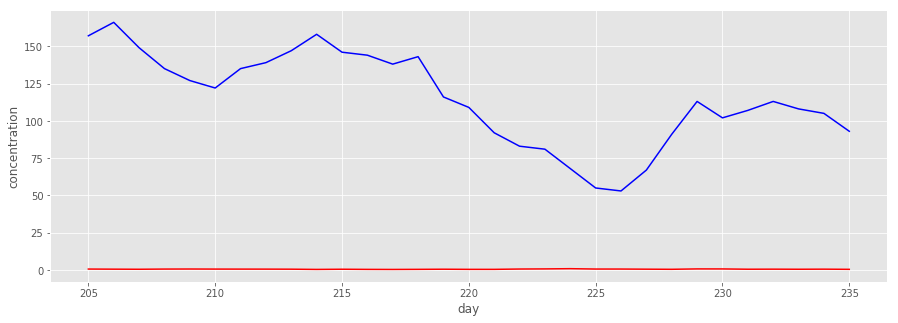

#---------------------------------------#
X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
83   2004-06  0.310593  0.476581  0.143509     0.430955
84   2004-06  0.185491  0.253535  0.045348     0.278056
y_train_walk:
 83    67.0
84    84.0
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
205   2004-10  0.627310  0.645918  0.449015     0.621381
206   2004-10  0.986332  0.392332  0.597165     0.451669
y_test_walk:
 205    166.0
206    149.0
Name: NO2(GT)(+2), dtype: float64
df_X and df_Y shape: 
 (122, 1, 4) (122, 5)
Train on 122 samples, validate on 31 samples
Epoch 1/50
 - 3s - loss: 115.0663 - val_loss: 112.6284
Epoch 2/50
 - 0s - loss: 115.0602 - val_loss: 112.6214
Epoch 3/50
 - 0s - loss: 115.0541 - val_loss: 112.6143
Epoch 4/50
 - 0s - loss: 115.0480 - val_loss: 112.6072
Epoch 5/50
 - 0s - loss: 115.0419 - val_loss: 112.6001
Epoch 6/50
 - 0s - loss: 115.0356 - val_loss: 112.5930
Epoch 7/50
 - 0s - loss: 1

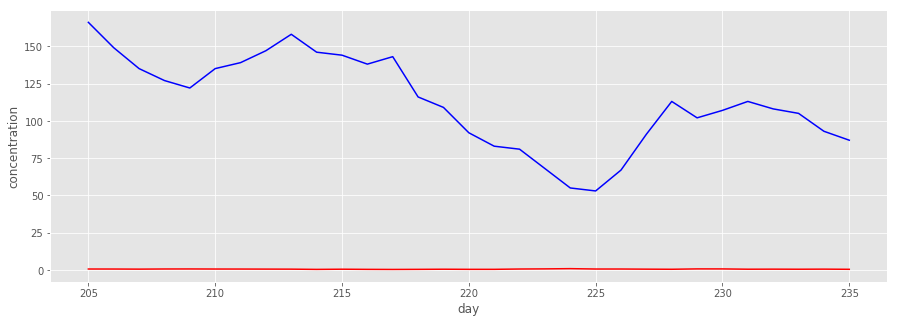

#---------------------------------------#
X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
83   2004-06  0.310593  0.476581  0.143509     0.430955
84   2004-06  0.185491  0.253535  0.045348     0.278056
y_train_walk:
 83    84.0
84    83.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
205   2004-10  0.627310  0.645918  0.449015     0.621381
206   2004-10  0.986332  0.392332  0.597165     0.451669
y_test_walk:
 205    149.0
206    135.0
Name: NO2(GT)(+3), dtype: float64
df_X and df_Y shape: 
 (122, 1, 4) (122, 5)
Train on 122 samples, validate on 31 samples
Epoch 1/50
 - 3s - loss: 115.8914 - val_loss: 109.7324
Epoch 2/50
 - 0s - loss: 115.8849 - val_loss: 109.7271
Epoch 3/50
 - 0s - loss: 115.8785 - val_loss: 109.7221
Epoch 4/50
 - 0s - loss: 115.8720 - val_loss: 109.7172
Epoch 5/50
 - 0s - loss: 115.8655 - val_loss: 109.7122
Epoch 6/50
 - 0s - loss: 115.8589 - val_loss: 109.7071
Epoch 7/50
 - 0s - loss: 1

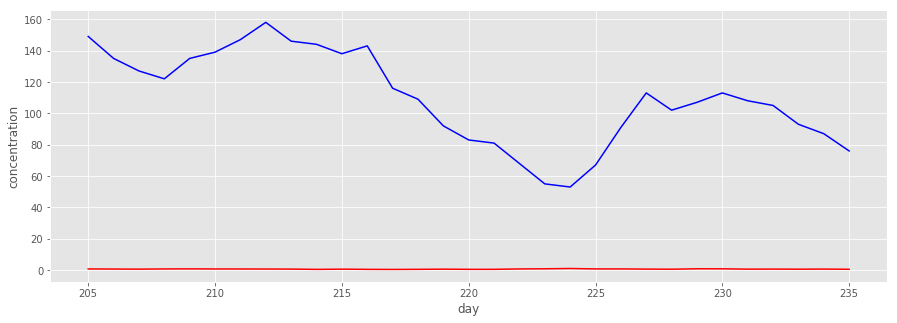

#---------------------------------------#
X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
83   2004-06  0.310593  0.476581  0.143509     0.430955
84   2004-06  0.185491  0.253535  0.045348     0.278056
y_train_walk:
 83    83.0
84    98.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
205   2004-10  0.627310  0.645918  0.449015     0.621381
206   2004-10  0.986332  0.392332  0.597165     0.451669
y_test_walk:
 205    135.0
206    127.0
Name: NO2(GT)(+4), dtype: float64
df_X and df_Y shape: 
 (122, 1, 4) (122, 5)
Train on 122 samples, validate on 31 samples
Epoch 1/50
 - 3s - loss: 116.4107 - val_loss: 107.9345
Epoch 2/50
 - 0s - loss: 116.4028 - val_loss: 107.9249
Epoch 3/50
 - 0s - loss: 116.3948 - val_loss: 107.9152
Epoch 4/50
 - 0s - loss: 116.3868 - val_loss: 107.9055
Epoch 5/50
 - 0s - loss: 116.3789 - val_loss: 107.8957
Epoch 6/50
 - 0s - loss: 116.3709 - val_loss: 107.8860
Epoch 7/50
 - 0s - loss: 1

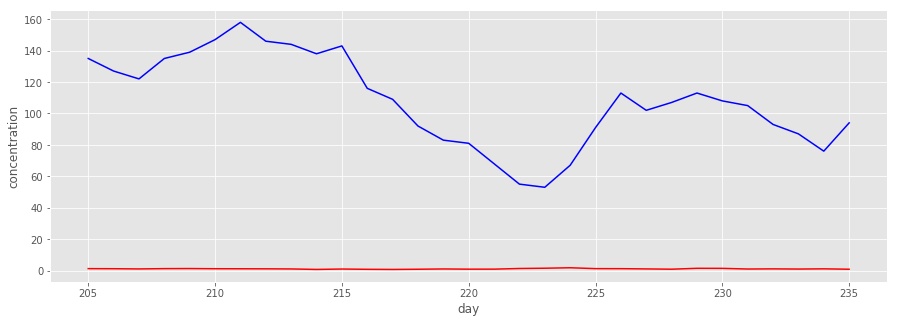

#---------------------------------------#
X_train_walk:
    YearMonth        CO      C6H6       NOx  PT08.S5(O3)
83   2004-06  0.310593  0.476581  0.143509     0.430955
84   2004-06  0.185491  0.253535  0.045348     0.278056
y_train_walk:
 83     98.0
84    114.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
205   2004-10  0.627310  0.645918  0.449015     0.621381
206   2004-10  0.986332  0.392332  0.597165     0.451669
y_test_walk:
 205    127.0
206    122.0
Name: NO2(GT)(+5), dtype: float64
df_X and df_Y shape: 
 (122, 1, 4) (122, 5)
Train on 122 samples, validate on 31 samples
Epoch 1/50
 - 3s - loss: 116.8748 - val_loss: 107.2012
Epoch 2/50
 - 0s - loss: 116.8677 - val_loss: 107.1925
Epoch 3/50
 - 0s - loss: 116.8607 - val_loss: 107.1839
Epoch 4/50
 - 0s - loss: 116.8539 - val_loss: 107.1754
Epoch 5/50
 - 0s - loss: 116.8471 - val_loss: 107.1670
Epoch 6/50
 - 0s - loss: 116.8402 - val_loss: 107.1583
Epoch 7/50
 - 0s - loss:

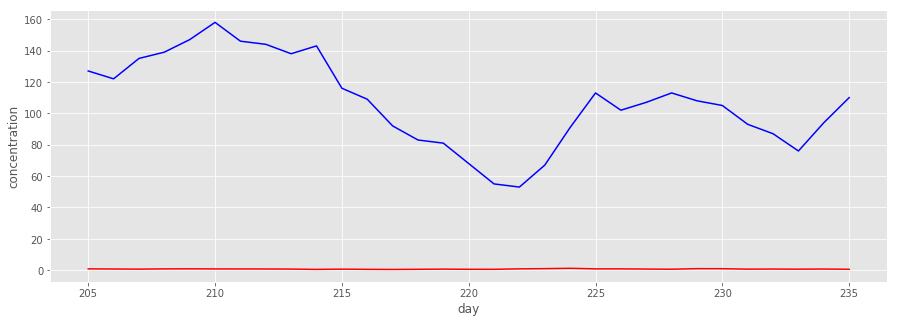

#---------------------------------------#
startYearMonth:  2004-07
X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
113   2004-07  0.384487  0.469984  0.129396     0.426412
114   2004-07  0.355660  0.449963  0.138602     0.408694
y_train_walk:
 113    134.0
114    119.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
236   2004-11  0.499388  0.526551  0.369694     0.700072
237   2004-11  0.777100  0.919458  0.571108     0.658832
y_test_walk:
 236    87.0
237    76.0
Name: NO2(GT)(+1), dtype: float64
df_X and df_Y shape: 
 (123, 1, 4) (123, 5)
Train on 123 samples, validate on 30 samples
Epoch 1/50
 - 4s - loss: 115.6587 - val_loss: 93.0266
Epoch 2/50
 - 0s - loss: 115.6489 - val_loss: 93.0142
Epoch 3/50
 - 0s - loss: 115.6389 - val_loss: 93.0015
Epoch 4/50
 - 0s - loss: 115.6287 - val_loss: 92.9886
Epoch 5/50
 - 0s - loss: 115.6182 - val_loss: 92.9754
Epoch 6/50
 - 0s - loss: 115.6076 - val_loss: 92.9620
Ep

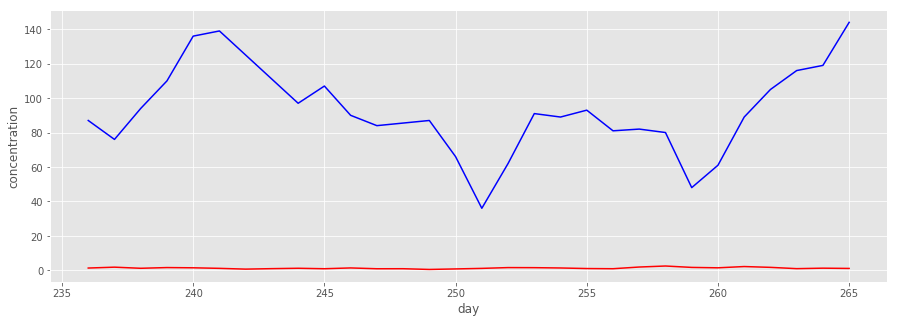

#---------------------------------------#
X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
113   2004-07  0.384487  0.469984  0.129396     0.426412
114   2004-07  0.355660  0.449963  0.138602     0.408694
y_train_walk:
 113    119.0
114    111.0
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
236   2004-11  0.499388  0.526551  0.369694     0.700072
237   2004-11  0.777100  0.919458  0.571108     0.658832
y_test_walk:
 236    76.0
237    94.0
Name: NO2(GT)(+2), dtype: float64
df_X and df_Y shape: 
 (123, 1, 4) (123, 5)
Train on 123 samples, validate on 30 samples
Epoch 1/50
 - 4s - loss: 115.2930 - val_loss: 94.2521
Epoch 2/50
 - 0s - loss: 115.2845 - val_loss: 94.2432
Epoch 3/50
 - 0s - loss: 115.2765 - val_loss: 94.2347
Epoch 4/50
 - 0s - loss: 115.2688 - val_loss: 94.2266
Epoch 5/50
 - 0s - loss: 115.2615 - val_loss: 94.2190
Epoch 6/50
 - 0s - loss: 115.2544 - val_loss: 94.2117
Epoch 7/50
 - 0s - loss: 11

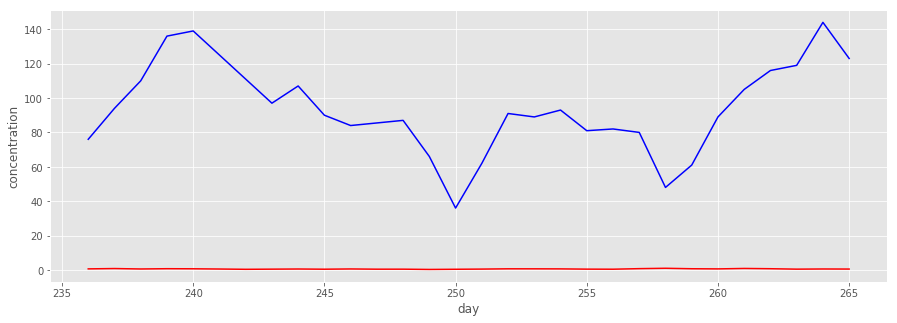

#---------------------------------------#
X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
113   2004-07  0.384487  0.469984  0.129396     0.426412
114   2004-07  0.355660  0.449963  0.138602     0.408694
y_train_walk:
 113    111.0
114    104.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
236   2004-11  0.499388  0.526551  0.369694     0.700072
237   2004-11  0.777100  0.919458  0.571108     0.658832
y_test_walk:
 236     94.0
237    110.0
Name: NO2(GT)(+3), dtype: float64
df_X and df_Y shape: 
 (123, 1, 4) (123, 5)
Train on 123 samples, validate on 30 samples
Epoch 1/50
 - 4s - loss: 114.9111 - val_loss: 95.1782
Epoch 2/50
 - 0s - loss: 114.9054 - val_loss: 95.1717
Epoch 3/50
 - 0s - loss: 114.8993 - val_loss: 95.1651
Epoch 4/50
 - 0s - loss: 114.8932 - val_loss: 95.1585
Epoch 5/50
 - 0s - loss: 114.8871 - val_loss: 95.1518
Epoch 6/50
 - 0s - loss: 114.8809 - val_loss: 95.1451
Epoch 7/50
 - 0s - loss: 

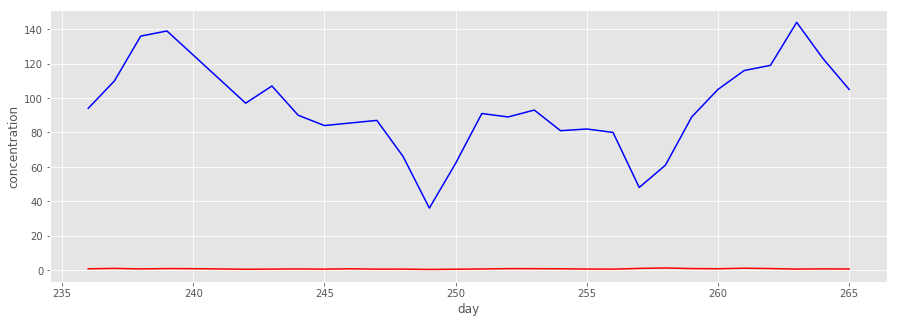

#---------------------------------------#
X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
113   2004-07  0.384487  0.469984  0.129396     0.426412
114   2004-07  0.355660  0.449963  0.138602     0.408694
y_train_walk:
 113    104.0
114     99.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
236   2004-11  0.499388  0.526551  0.369694     0.700072
237   2004-11  0.777100  0.919458  0.571108     0.658832
y_test_walk:
 236    110.0
237    136.0
Name: NO2(GT)(+4), dtype: float64
df_X and df_Y shape: 
 (123, 1, 4) (123, 5)
Train on 123 samples, validate on 30 samples
Epoch 1/50
 - 4s - loss: 114.7771 - val_loss: 95.1560
Epoch 2/50
 - 0s - loss: 114.7694 - val_loss: 95.1469
Epoch 3/50
 - 0s - loss: 114.7616 - val_loss: 95.1378
Epoch 4/50
 - 0s - loss: 114.7539 - val_loss: 95.1288
Epoch 5/50
 - 0s - loss: 114.7462 - val_loss: 95.1199
Epoch 6/50
 - 0s - loss: 114.7385 - val_loss: 95.1111
Epoch 7/50
 - 0s - loss: 

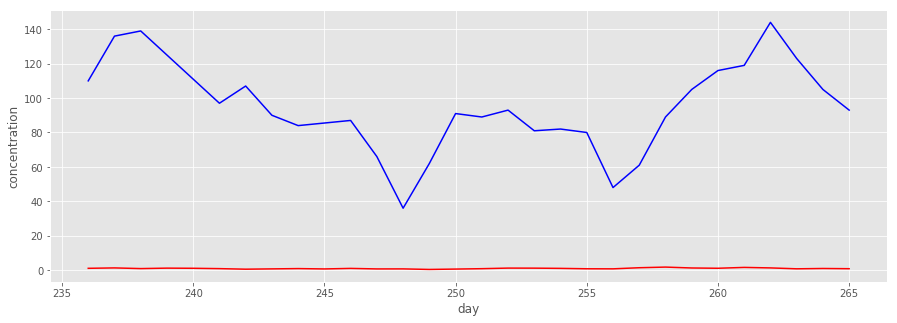

#---------------------------------------#
X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
113   2004-07  0.384487  0.469984  0.129396     0.426412
114   2004-07  0.355660  0.449963  0.138602     0.408694
y_train_walk:
 113     99.0
114    110.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
236   2004-11  0.499388  0.526551  0.369694     0.700072
237   2004-11  0.777100  0.919458  0.571108     0.658832
y_test_walk:
 236    136.0
237    139.0
Name: NO2(GT)(+5), dtype: float64
df_X and df_Y shape: 
 (123, 1, 4) (123, 5)
Train on 123 samples, validate on 30 samples
Epoch 1/50
 - 4s - loss: 114.7524 - val_loss: 94.2342
Epoch 2/50
 - 0s - loss: 114.7417 - val_loss: 94.2210
Epoch 3/50
 - 0s - loss: 114.7306 - val_loss: 94.2075
Epoch 4/50
 - 0s - loss: 114.7192 - val_loss: 94.1936
Epoch 5/50
 - 0s - loss: 114.7076 - val_loss: 94.1793
Epoch 6/50
 - 0s - loss: 114.6957 - val_loss: 94.1647
Epoch 7/50
 - 0s - loss: 

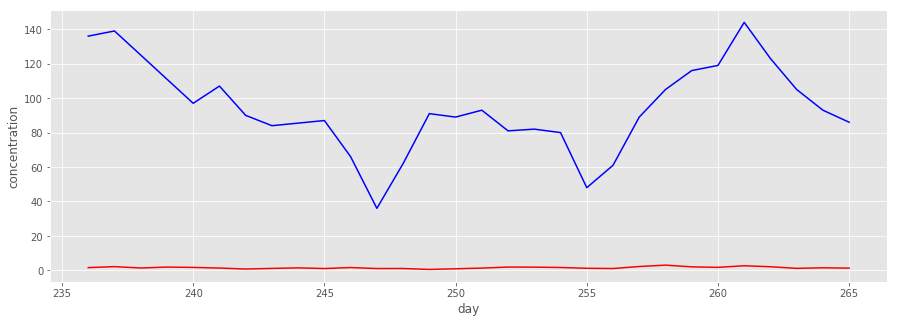

#---------------------------------------#
startYearMonth:  2004-08
X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
144   2004-08  0.154685  0.191071  0.022186     0.182227
145   2004-08  0.218023  0.339900  0.064948     0.240832
y_train_walk:
 144    137.0
145    143.0
Name: NO2(GT)(+1), dtype: float64
X_test_walk:
     YearMonth       CO      C6H6       NOx  PT08.S5(O3)
266   2004-12  0.56841  0.522408  0.596671     0.512176
267   2004-12  0.69874  0.715476  0.706703     0.623960
y_test_walk:
 266    123.0
267    105.0
Name: NO2(GT)(+1), dtype: float64
df_X and df_Y shape: 
 (122, 1, 4) (122, 5)
Train on 122 samples, validate on 31 samples
Epoch 1/50
 - 5s - loss: 109.7316 - val_loss: 86.7589
Epoch 2/50
 - 0s - loss: 109.7263 - val_loss: 86.7538
Epoch 3/50
 - 0s - loss: 109.7211 - val_loss: 86.7489
Epoch 4/50
 - 0s - loss: 109.7161 - val_loss: 86.7442
Epoch 5/50
 - 0s - loss: 109.7112 - val_loss: 86.7397
Epoch 6/50
 - 0s - loss: 109.7065 - val_loss: 86.7353
Epo

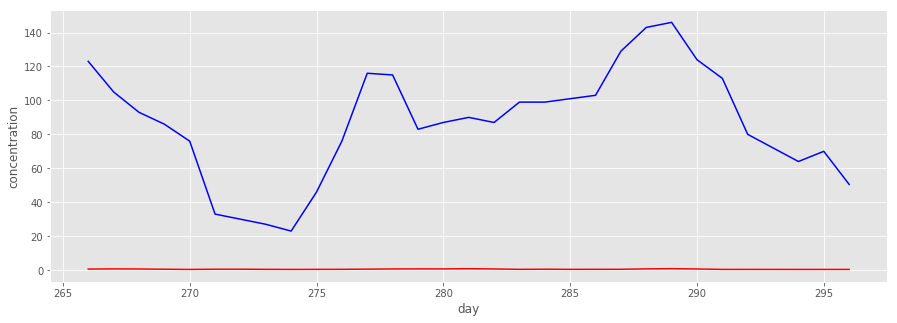

#---------------------------------------#
X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
144   2004-08  0.154685  0.191071  0.022186     0.182227
145   2004-08  0.218023  0.339900  0.064948     0.240832
y_train_walk:
 144    143.0
145    177.0
Name: NO2(GT)(+2), dtype: float64
X_test_walk:
     YearMonth       CO      C6H6       NOx  PT08.S5(O3)
266   2004-12  0.56841  0.522408  0.596671     0.512176
267   2004-12  0.69874  0.715476  0.706703     0.623960
y_test_walk:
 266    105.0
267     93.0
Name: NO2(GT)(+2), dtype: float64
df_X and df_Y shape: 
 (122, 1, 4) (122, 5)
Train on 122 samples, validate on 31 samples
Epoch 1/50
 - 5s - loss: 109.6191 - val_loss: 83.7981
Epoch 2/50
 - 0s - loss: 109.6135 - val_loss: 83.7921
Epoch 3/50
 - 0s - loss: 109.6079 - val_loss: 83.7864
Epoch 4/50
 - 0s - loss: 109.6025 - val_loss: 83.7810
Epoch 5/50
 - 0s - loss: 109.5973 - val_loss: 83.7757
Epoch 6/50
 - 0s - loss: 109.5921 - val_loss: 83.7705
Epoch 7/50
 - 0s - loss: 109

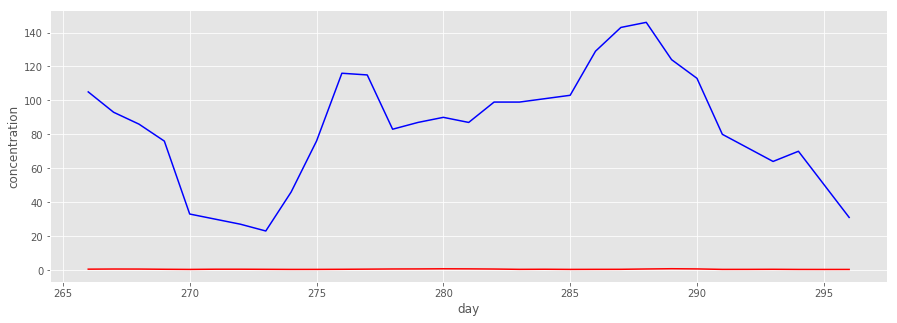

#---------------------------------------#
X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
144   2004-08  0.154685  0.191071  0.022186     0.182227
145   2004-08  0.218023  0.339900  0.064948     0.240832
y_train_walk:
 144    177.0
145    138.0
Name: NO2(GT)(+3), dtype: float64
X_test_walk:
     YearMonth       CO      C6H6       NOx  PT08.S5(O3)
266   2004-12  0.56841  0.522408  0.596671     0.512176
267   2004-12  0.69874  0.715476  0.706703     0.623960
y_test_walk:
 266    93.0
267    86.0
Name: NO2(GT)(+3), dtype: float64
df_X and df_Y shape: 
 (122, 1, 4) (122, 5)
Train on 122 samples, validate on 31 samples
Epoch 1/50
 - 5s - loss: 109.2536 - val_loss: 81.0596
Epoch 2/50
 - 0s - loss: 109.2442 - val_loss: 81.0493
Epoch 3/50
 - 0s - loss: 109.2345 - val_loss: 81.0387
Epoch 4/50
 - 0s - loss: 109.2245 - val_loss: 81.0277
Epoch 5/50
 - 0s - loss: 109.2142 - val_loss: 81.0165
Epoch 6/50
 - 0s - loss: 109.2037 - val_loss: 81.0051
Epoch 7/50
 - 0s - loss: 109.1

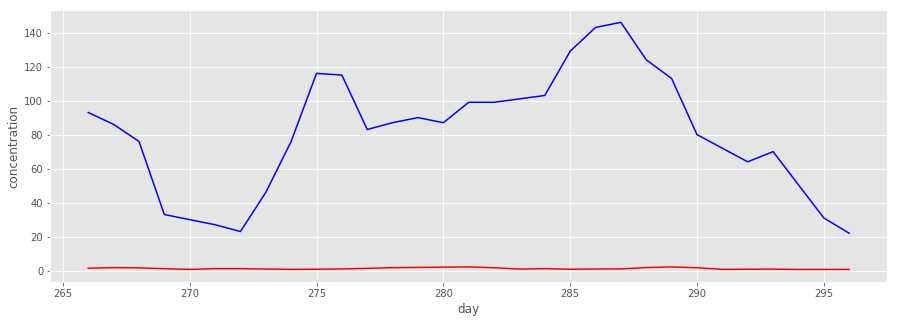

#---------------------------------------#
X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
144   2004-08  0.154685  0.191071  0.022186     0.182227
145   2004-08  0.218023  0.339900  0.064948     0.240832
y_train_walk:
 144    138.0
145    117.0
Name: NO2(GT)(+4), dtype: float64
X_test_walk:
     YearMonth       CO      C6H6       NOx  PT08.S5(O3)
266   2004-12  0.56841  0.522408  0.596671     0.512176
267   2004-12  0.69874  0.715476  0.706703     0.623960
y_test_walk:
 266    86.0
267    76.0
Name: NO2(GT)(+4), dtype: float64
df_X and df_Y shape: 
 (122, 1, 4) (122, 5)
Train on 122 samples, validate on 31 samples
Epoch 1/50
 - 6s - loss: 108.6412 - val_loss: 79.6502
Epoch 2/50
 - 0s - loss: 108.6322 - val_loss: 79.6404
Epoch 3/50
 - 0s - loss: 108.6229 - val_loss: 79.6307
Epoch 4/50
 - 0s - loss: 108.6137 - val_loss: 79.6210
Epoch 5/50
 - 0s - loss: 108.6046 - val_loss: 79.6113
Epoch 6/50
 - 0s - loss: 108.5954 - val_loss: 79.6017
Epoch 7/50
 - 0s - loss: 108.5

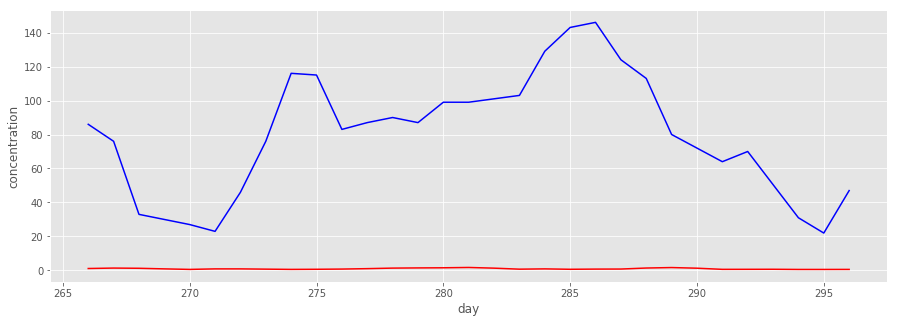

#---------------------------------------#
X_train_walk:
     YearMonth        CO      C6H6       NOx  PT08.S5(O3)
144   2004-08  0.154685  0.191071  0.022186     0.182227
145   2004-08  0.218023  0.339900  0.064948     0.240832
y_train_walk:
 144    117.0
145    107.0
Name: NO2(GT)(+5), dtype: float64
X_test_walk:
     YearMonth       CO      C6H6       NOx  PT08.S5(O3)
266   2004-12  0.56841  0.522408  0.596671     0.512176
267   2004-12  0.69874  0.715476  0.706703     0.623960
y_test_walk:
 266    76.0
267    33.0
Name: NO2(GT)(+5), dtype: float64
df_X and df_Y shape: 
 (122, 1, 4) (122, 5)
Train on 122 samples, validate on 31 samples
Epoch 1/50
 - 6s - loss: 108.1999 - val_loss: 79.7100
Epoch 2/50
 - 0s - loss: 108.1936 - val_loss: 79.7033
Epoch 3/50
 - 0s - loss: 108.1875 - val_loss: 79.6969
Epoch 4/50
 - 0s - loss: 108.1816 - val_loss: 79.6906
Epoch 5/50
 - 0s - loss: 108.1758 - val_loss: 79.6845
Epoch 6/50
 - 0s - loss: 108.1702 - val_loss: 79.6786
Epoch 7/50
 - 0s - loss: 108.1

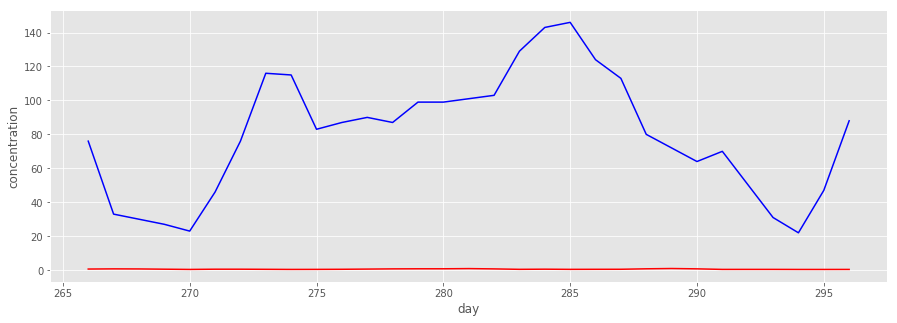

#---------------------------------------#
startYearMonth:  2004-09
[[121.90002505605688, 121.47521895298331, 122.95271670435746, 125.43038048443492, 126.38333879903826], [126.5598921349967, 125.07731452764963, 123.46099077659407, 119.95316901828689, 117.9227333642474], [116.0418315890877, 118.0487512692879, 121.45328410906824, 123.90324753358081, 125.15845483456192], [118.37548060781732, 116.02244368673145, 112.90275165725873, 110.60530551003171, 110.01182723962721], [95.11244338054534, 97.0340820146815, 97.83483685027939, 97.48623975968292, 96.1040685524258], [92.10137901503666, 89.66959046627193, 87.01501030956003, 86.11064254271412, 86.5702105456204]]


In [22]:
def train_rnn_model(df_X, df_y, futureYList, rnnModelList, evaResList, rnn_hidden_neurons=8):    
    plt.figure(figsize=(10,5))
    
    month_shift = 4
    
    for startYearMonth in df_X.YearMonth.unique():
        print('startYearMonth: ', startYearMonth)
        if startYearMonth.month == 12 - month_shift + 1: # stopping criteria
            break 
        iterList = []
        for i, labelY in enumerate(futureYList):
            rangeTrainArr = [x for x in range(startYearMonth.month, startYearMonth.month+month_shift)]
            rangeTestArr = [startYearMonth.month+month_shift]
            rangeTrainPeriodArray = [x for x in df_X.YearMonth.unique() if x.month in rangeTrainArr]
            rangeTestPeriodArray = [x for x in df_X.YearMonth.unique() if x.month in rangeTestArr]   
            # segmentaion, use YearMonth as index
            X_train_walk = df_X.loc[df_X.YearMonth.isin(rangeTrainPeriodArray)].copy()
            X_test_walk = df_X.loc[df_X.YearMonth.isin(rangeTestPeriodArray)].copy()        
            y_train_walk = df_y[df_y.index.isin(X_train_walk.index)].copy()
            y_test_walk = df_y[df_y.index.isin(X_test_walk.index)].copy()
            print('X_train_walk:\n', X_train_walk.iloc[:2,:])
            print('y_train_walk:\n', y_train_walk[labelY].iloc[:2])
            print('X_test_walk:\n', X_test_walk.iloc[:2,:])
            print('y_test_walk:\n', y_test_walk[labelY].iloc[:2])
            # drop YearMonth
            X_train_walk.drop(columns=['YearMonth'], inplace=True)
            X_test_walk.drop(columns=['YearMonth'], inplace=True)       
            
            # reshape input feature to be 3 Dimension, ie. [samples, timesteps, features]
            X_train_rnn = X_train_walk.values.reshape((X_train_walk.shape[0], 1, X_train_walk.shape[1])) # np.array            
            X_test_rnn = X_test_walk.values.reshape((X_test_walk.shape[0], 1, X_test_walk.shape[1])) # np.array            
            print('df_X and df_Y shape: \n', X_train_rnn.shape, y_train_walk.shape)            
            # design network            
            model = Sequential()
            model.add(LSTM(rnn_hidden_neurons,
                           activation='relu',
                           kernel_initializer='glorot_uniform',
                           input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
            model.add(Dense(1))
            model.compile(loss='mae', optimizer='adam')
            # fit network            
            # Set callback functions to early stop training and save the best model so far
            modelName = "rnnModel" + str(i) + ".h5"
            callbacks = [EarlyStopping(monitor='val_loss', patience=5),
                         ModelCheckpoint(filepath=modelName, monitor='val_loss', save_best_only=True)]            
            history = model.fit(X_train_rnn, y_train_walk[labelY].values, 
                                epochs=50, 
                                batch_size=32, 
                                validation_data=(X_test_rnn, y_test_walk[labelY].values), 
                                callbacks=callbacks, # Early stopping
                                verbose=2, 
                                shuffle=False)
            # predict
            y_pred = model.predict(X_test_rnn, verbose=1) # batch_size default 32            
            # eval
            print('The rmse of prediction is:', mean_squared_error(y_test_walk.iloc[:, i], y_pred) ** 0.5)             
            iterList.append(mean_squared_error(y_test_walk.iloc[:, i], y_pred) ** 0.5)
            
            # save model name                        
            if(startYearMonth.month == 3): 
                rnnModelList.append(modelName)
            # serialize weights to HDF5
            model.save_weights(modelName)
            print("Saved model" + modelName + "to disk")
            
            # plot
            plt.figure(figsize=(15,5))
            x = X_test_walk.index
            plt.subplot(1, 1, 1)
            plt.plot(x,y_test_walk.iloc[:, i],'b')            
            plt.plot(x,y_pred,'r')
            plt.xlabel('day')
            plt.ylabel('concentration')

            plt.show()      
            print('#---------------------------------------#')            
        evaResList.append(iterList)
    plt.show()
    return evaResList
            
rnnModelList = []
evaResList = []
evaResList = train_rnn_model(X_train_norm, y_train, futureYList, rnnModelList, evaResList)
print(evaResList)

Starting predicting...

rnnModelList:  ['rnnModel0.h5', 'rnnModel1.h5', 'rnnModel2.h5', 'rnnModel3.h5', 'rnnModel4.h5']
modelName file: rnnModel0.h5
  YearMonth        CO      C6H6       NOx  PT08.S5(O3)
0   2005-01  0.458419  0.342750  0.390219     0.523442
1   2005-01  0.440853  0.328638  0.418215     0.577390
df_X and df_Y shape: 
 (94, 1, 4) (94, 5)
Loaded model from disk
94/94 [==============================] - 2s 22ms/step
The rmse of prediction is: 96.46195661236207


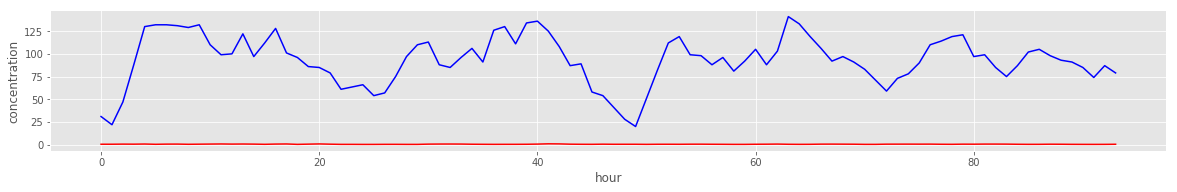

modelName file: rnnModel1.h5
  YearMonth        CO      C6H6       NOx  PT08.S5(O3)
0   2005-01  0.458419  0.342750  0.390219     0.523442
1   2005-01  0.440853  0.328638  0.418215     0.577390
df_X and df_Y shape: 
 (94, 1, 4) (94, 5)
Loaded model from disk
94/94 [==============================] - 2s 24ms/step
The rmse of prediction is: 96.80732570787467


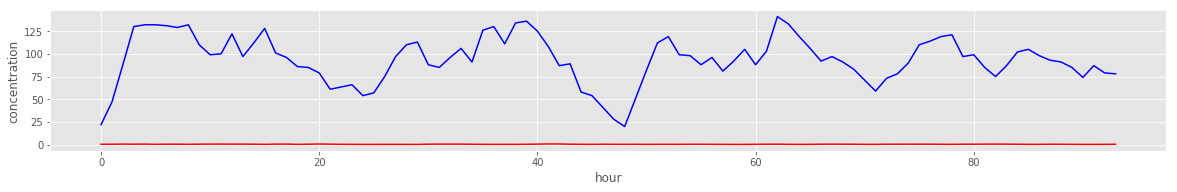

modelName file: rnnModel2.h5
  YearMonth        CO      C6H6       NOx  PT08.S5(O3)
0   2005-01  0.458419  0.342750  0.390219     0.523442
1   2005-01  0.440853  0.328638  0.418215     0.577390
df_X and df_Y shape: 
 (94, 1, 4) (94, 5)
Loaded model from disk
94/94 [==============================] - 2s 24ms/step
The rmse of prediction is: 96.3238051997974


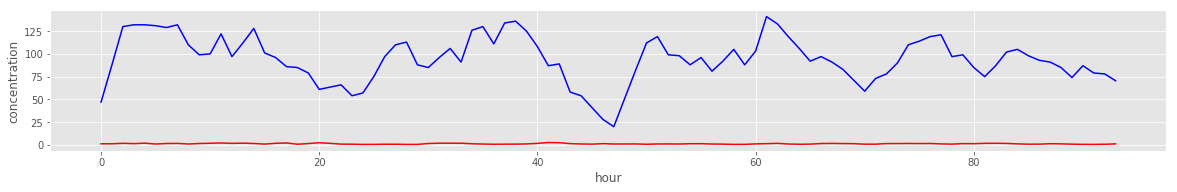

modelName file: rnnModel3.h5
  YearMonth        CO      C6H6       NOx  PT08.S5(O3)
0   2005-01  0.458419  0.342750  0.390219     0.523442
1   2005-01  0.440853  0.328638  0.418215     0.577390
df_X and df_Y shape: 
 (94, 1, 4) (94, 5)
Loaded model from disk
94/94 [==============================] - 2s 25ms/step
The rmse of prediction is: 96.67466874977549


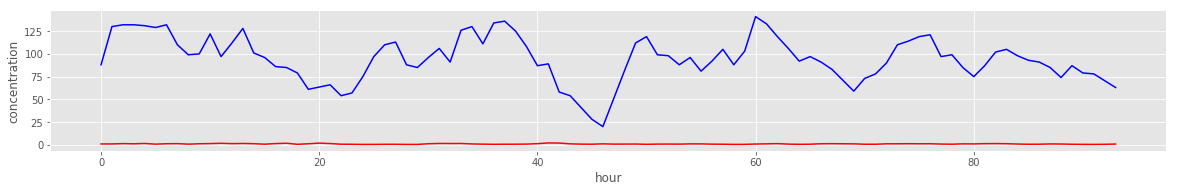

modelName file: rnnModel4.h5
  YearMonth        CO      C6H6       NOx  PT08.S5(O3)
0   2005-01  0.458419  0.342750  0.390219     0.523442
1   2005-01  0.440853  0.328638  0.418215     0.577390
df_X and df_Y shape: 
 (94, 1, 4) (94, 5)
Loaded model from disk
94/94 [==============================] - 3s 28ms/step
The rmse of prediction is: 96.75960111778254


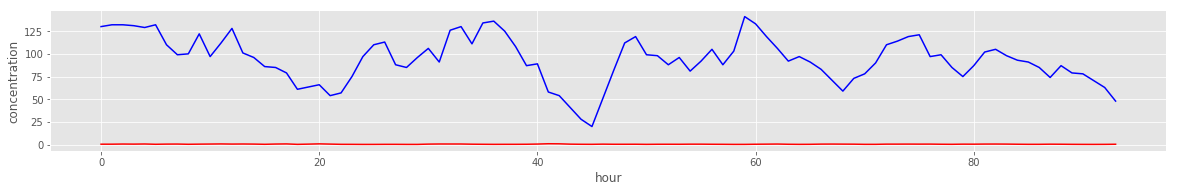

In [23]:
print('Starting predicting...\n')

# model predict and show result seperately
def validation_rnn_model(df_X, df_y, rnnModelList, rnn_hidden_neurons=8):
    print('rnnModelList: ', rnnModelList)
    
    for i, modelName in enumerate(rnnModelList):
        print('modelName file: {}'.format(modelName))
        # drop YearMonth
        X_valid = df_X.drop(columns=['YearMonth'])
        print(df_X.iloc[:2,:])        
        # reshape input feature to be 3 Dimension, ie. [samples, timesteps, features]
        X_valid_rnn = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1])) # np.array                    
        print('df_X and df_Y shape: \n', X_valid_rnn.shape, df_y.shape)                    
        
        # call model
        model = Sequential()
        model.add(LSTM(rnn_hidden_neurons, 
                        activation='relu', 
                        kernel_initializer='glorot_uniform',
                        input_shape=(X_valid_rnn.shape[1], X_valid_rnn.shape[2])))        
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        # load weights after compile
        model.load_weights(modelName)
        print("Loaded model from disk")                
        
        # predict
        y_pred = model.predict(X_valid_rnn, verbose=1) # batch_size default 32

        # eval
        print('The rmse of prediction is:', mean_squared_error(df_y.iloc[:, i], y_pred) ** 0.5)    
        # plot
        plt.figure(figsize=(20,15))            
        x = df_X.index
        plt.subplot(len(lgbmModelList), 1, i+1)
        plt.plot(x,y_pred,'r')
        plt.plot(x,y_valid.iloc[:, i],'b')
        plt.xlabel('hour')
        plt.ylabel('concentration')

        plt.show()
        
validation_rnn_model(X_valid_norm, y_valid, rnnModelList)   